In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-virussign-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 141s - loss: 0.8656 - acc: 0.7458 - val_loss: 3.0220 - val_acc: 0.0850
Epoch 2/100
9112/9112 [==============================] - 137s - loss: 0.4584 - acc: 0.8611 - val_loss: 0.7905 - val_acc: 0.7871
Epoch 3/100
9112/9112 [==============================] - 137s - loss: 0.3462 - acc: 0.8942 - val_loss: 0.7304 - val_acc: 0.8330
Epoch 4/100
9112/9112 [==============================] - 137s - loss: 0.2692 - acc: 0.9178 - val_loss: 0.7874 - val_acc: 0.7822
Epoch 5/100
9112/9112 [==============================] - 137s - loss: 0.2172 - acc: 0.9309 - val_loss: 0.3460 - val_acc: 0.9111
Epoch 6/100
9112/9112 [==============================] - 137s - loss: 0.1562 - acc: 0.9520 - val_loss: 0.4092 - val_acc: 0.9111
Epoch 7/100
9112/9112 [==============================] - 137s - loss: 0.1438 - acc: 0.9558 - val_loss: 0.6643 - val_acc: 0.8555
Epoch 8/100
9112/9112 [==============================] -

9114/9114 [==============================] - 136s - loss: 0.0477 - acc: 0.9819 - val_loss: 1.6036 - val_acc: 0.8356
Epoch 27/100
9114/9114 [==============================] - 137s - loss: 0.0422 - acc: 0.9869 - val_loss: 0.3297 - val_acc: 0.9266
Epoch 28/100
9114/9114 [==============================] - 137s - loss: 0.0171 - acc: 0.9944 - val_loss: 0.4219 - val_acc: 0.9002
Epoch 29/100
9114/9114 [==============================] - 137s - loss: 0.0728 - acc: 0.9759 - val_loss: 1.7019 - val_acc: 0.7701
Epoch 30/100
9114/9114 [==============================] - 137s - loss: 0.0365 - acc: 0.9884 - val_loss: 0.3079 - val_acc: 0.9354
Epoch 31/100
9114/9114 [==============================] - 136s - loss: 0.0219 - acc: 0.9941 - val_loss: 0.3400 - val_acc: 0.9364
Epoch 32/100
9114/9114 [==============================] - 136s - loss: 0.0196 - acc: 0.9936 - val_loss: 0.5076 - val_acc: 0.9070
Epoch 33/100
9114/9114 [==============================] - 136s - loss: 0.0237 - acc: 0.9936 - val_loss: 0.5494

9116/9116 [==============================] - 137s - loss: 0.0029 - acc: 0.9995 - val_loss: 0.4001 - val_acc: 0.9461
Epoch 52/100
9116/9116 [==============================] - 136s - loss: 0.0407 - acc: 0.9876 - val_loss: 0.8358 - val_acc: 0.8686
Epoch 53/100
9116/9116 [==============================] - 136s - loss: 0.0378 - acc: 0.9882 - val_loss: 0.3864 - val_acc: 0.9353
Epoch 54/100
9116/9116 [==============================] - 136s - loss: 0.0123 - acc: 0.9961 - val_loss: 0.3724 - val_acc: 0.9392
Epoch 55/100
9116/9116 [==============================] - 137s - loss: 0.0031 - acc: 0.9995 - val_loss: 0.3858 - val_acc: 0.9422
Epoch 56/100
9116/9116 [==============================] - 136s - loss: 0.0052 - acc: 0.9985 - val_loss: 0.3967 - val_acc: 0.9402
Epoch 57/100
9116/9116 [==============================] - 137s - loss: 0.0110 - acc: 0.9969 - val_loss: 0.3991 - val_acc: 0.9294
Epoch 58/100
9116/9116 [==============================] - 137s - loss: 0.0156 - acc: 0.9952 - val_loss: 0.4937

9120/9120 [==============================] - 136s - loss: 0.0014 - acc: 0.9997 - val_loss: 0.4611 - val_acc: 0.9301
Epoch 77/100
9120/9120 [==============================] - 136s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.4819 - val_acc: 0.9331
Epoch 78/100
9120/9120 [==============================] - 136s - loss: 0.0033 - acc: 0.9990 - val_loss: 0.6346 - val_acc: 0.9163
Epoch 79/100
9120/9120 [==============================] - 136s - loss: 0.0239 - acc: 0.9928 - val_loss: 0.8255 - val_acc: 0.8927
Epoch 80/100
9120/9120 [==============================] - 136s - loss: 0.0182 - acc: 0.9948 - val_loss: 0.5105 - val_acc: 0.9242
Epoch 81/100
9120/9120 [==============================] - 136s - loss: 0.0070 - acc: 0.9979 - val_loss: 0.5128 - val_acc: 0.9301
Epoch 82/100
9120/9120 [==============================] - 136s - loss: 0.0129 - acc: 0.9966 - val_loss: 0.5745 - val_acc: 0.9144
Epoch 83/100
9120/9120 [==============================] - 136s - loss: 0.0040 - acc: 0.9988 - val_loss: 0.6209

Train on 9125 samples, validate on 1011 samples
Epoch 1/100
9125/9125 [==============================] - 136s - loss: 2.7863 - acc: 0.3791 - val_loss: 10.0620 - val_acc: 0.1958
Epoch 2/100
9125/9125 [==============================] - 137s - loss: 1.3162 - acc: 0.6539 - val_loss: 0.8182 - val_acc: 0.7399
Epoch 3/100
9125/9125 [==============================] - 137s - loss: 0.7714 - acc: 0.7675 - val_loss: 0.5556 - val_acc: 0.8269
Epoch 4/100
9125/9125 [==============================] - 137s - loss: 0.6019 - acc: 0.8190 - val_loss: 0.5607 - val_acc: 0.8239
Epoch 5/100
9125/9125 [==============================] - 136s - loss: 0.4863 - acc: 0.8498 - val_loss: 1.0511 - val_acc: 0.7676
Epoch 6/100
9125/9125 [==============================] - 136s - loss: 0.4265 - acc: 0.8694 - val_loss: 0.4908 - val_acc: 0.8477
Epoch 7/100
9125/9125 [==============================] - 138s - loss: 0.3542 - acc: 0.8864 - val_loss: 0.3946 - val_acc: 0.8813
Epoch 8/100
9125/9125 [==============================] 

9127/9127 [==============================] - 137s - loss: 0.0740 - acc: 0.9758 - val_loss: 0.5793 - val_acc: 0.8682
Epoch 27/100
9127/9127 [==============================] - 137s - loss: 0.0445 - acc: 0.9864 - val_loss: 0.3751 - val_acc: 0.9158
Epoch 28/100
9127/9127 [==============================] - 136s - loss: 0.0330 - acc: 0.9902 - val_loss: 0.3259 - val_acc: 0.9356
Epoch 29/100
9127/9127 [==============================] - 137s - loss: 0.0249 - acc: 0.9924 - val_loss: 0.3790 - val_acc: 0.9336
Epoch 30/100
9127/9127 [==============================] - 137s - loss: 0.0289 - acc: 0.9905 - val_loss: 0.4659 - val_acc: 0.9058
Epoch 31/100
9127/9127 [==============================] - 137s - loss: 0.0450 - acc: 0.9862 - val_loss: 0.4782 - val_acc: 0.9197
Epoch 32/100
9127/9127 [==============================] - 137s - loss: 0.0424 - acc: 0.9878 - val_loss: 0.3473 - val_acc: 0.9277
Epoch 33/100
9127/9127 [==============================] - 137s - loss: 0.0225 - acc: 0.9933 - val_loss: 0.3999

9128/9128 [==============================] - 137s - loss: 0.0034 - acc: 0.9992 - val_loss: 0.3660 - val_acc: 0.9405
Epoch 52/100
9128/9128 [==============================] - 138s - loss: 0.0062 - acc: 0.9985 - val_loss: 0.4189 - val_acc: 0.9355
Epoch 53/100
9128/9128 [==============================] - 137s - loss: 0.0426 - acc: 0.9853 - val_loss: 0.4660 - val_acc: 0.9157
Epoch 54/100
9128/9128 [==============================] - 136s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.4047 - val_acc: 0.9415
Epoch 55/100
9128/9128 [==============================] - 136s - loss: 0.0190 - acc: 0.9949 - val_loss: 0.5330 - val_acc: 0.9246
Epoch 56/100
9128/9128 [==============================] - 137s - loss: 0.0091 - acc: 0.9972 - val_loss: 0.3727 - val_acc: 0.9355
Epoch 57/100
9128/9128 [==============================] - 138s - loss: 0.0103 - acc: 0.9964 - val_loss: 0.5134 - val_acc: 0.9266
Epoch 58/100
9128/9128 [==============================] - 137s - loss: 0.0111 - acc: 0.9962 - val_loss: 0.4037

9130/9130 [==============================] - 135s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.3356 - val_acc: 0.9453
Epoch 77/100
9130/9130 [==============================] - 135s - loss: 0.0027 - acc: 0.9993 - val_loss: 0.4775 - val_acc: 0.9284
Epoch 78/100
9130/9130 [==============================] - 137s - loss: 0.0090 - acc: 0.9968 - val_loss: 0.4189 - val_acc: 0.9394
Epoch 79/100
9130/9130 [==============================] - 136s - loss: 0.0131 - acc: 0.9961 - val_loss: 0.4321 - val_acc: 0.9414
Epoch 80/100
6112/9130 [===================>..........] - ETA: 43s - loss: 0.0115 - acc: 0.9972

In [22]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9405


In [23]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

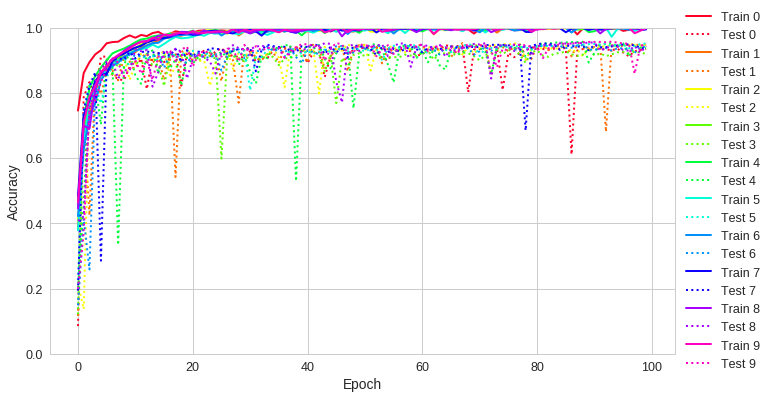

In [24]:
plot_acc(history)

In [25]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

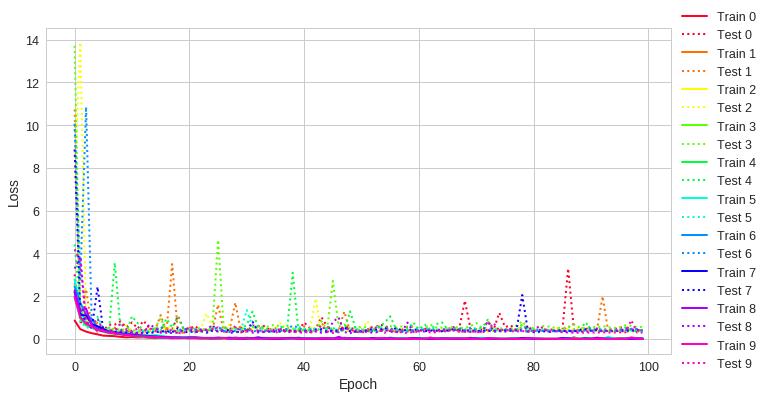

In [26]:
plot_loss(history)

Plotting the confusion matrix


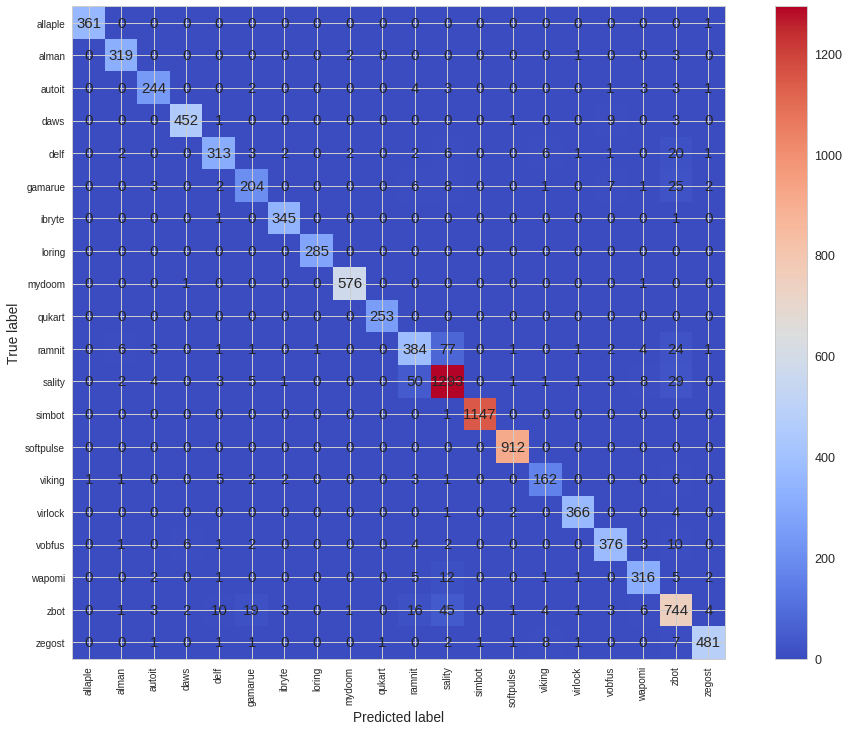

In [27]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


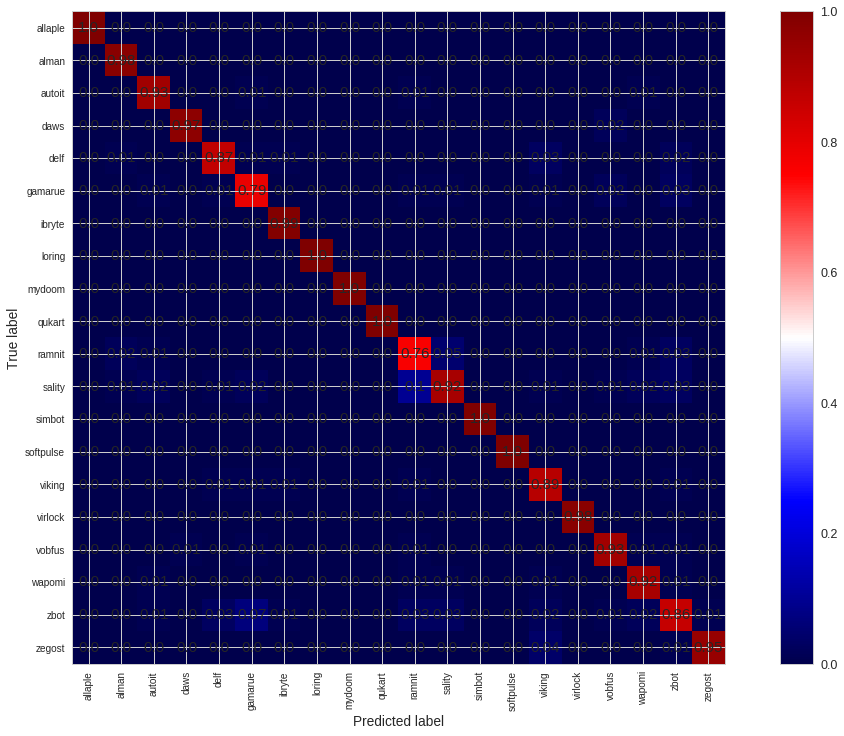

In [28]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


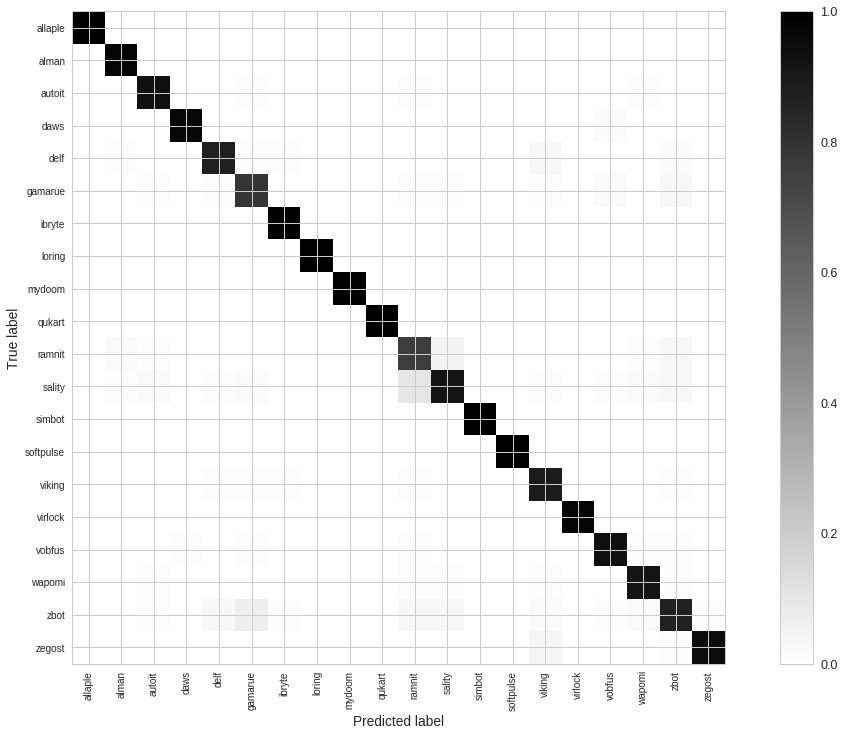

In [29]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


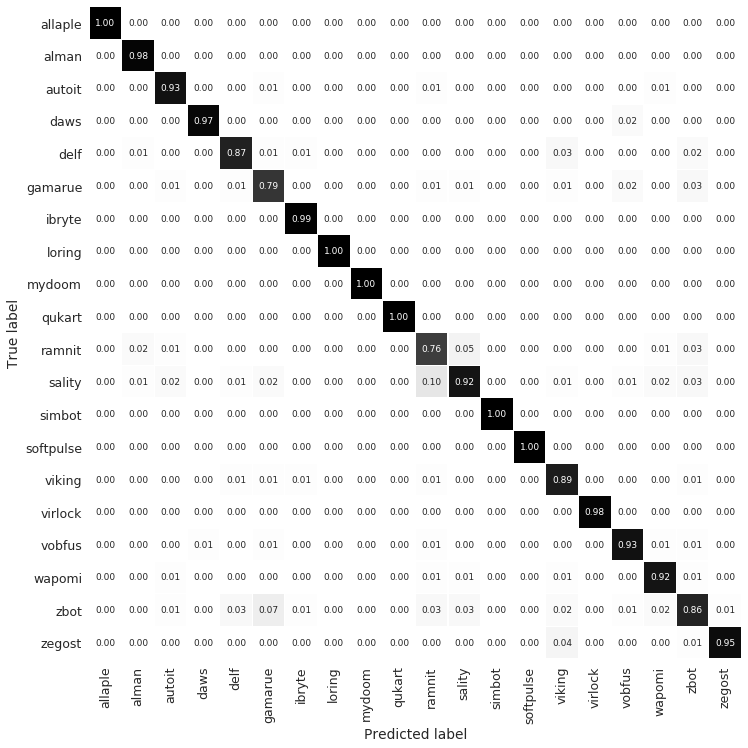

In [30]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
for h in history:
    print(h.history)

{'val_loss': [3.0220468826591969, 0.79052748840973663, 0.73037212951444985, 0.78740206293866777, 0.34598728296890435, 0.40923154429834518, 0.66431384989891074, 0.6722128156116014, 0.82559703503294601, 0.53919850600511232, 0.77990151298126875, 0.49018417049856211, 0.85405932083085645, 0.51012042411116543, 0.4284481474445565, 0.55901569145953811, 0.48016540690114606, 0.46286640861612449, 1.0786678532051619, 0.46017416946012624, 0.47615901212545753, 0.61061800489754514, 0.37084715929854317, 0.45347396351006442, 0.47414150080525674, 0.37638747834166342, 0.54626201814774422, 0.48523566779468741, 0.51627867480856349, 0.52684410791886238, 0.35544470175211362, 0.63262119308928932, 0.59143634805746315, 0.60590715933927042, 0.43193329079697262, 0.4402053672140771, 0.44271852862354599, 0.38815801969804342, 0.40477659005522115, 0.39704323567439381, 0.77399826781828551, 0.51330829361183472, 0.46513413935572556, 1.0236011521518815, 0.59393633191230855, 0.39630039844058684, 0.42900992516008296, 0.580

In [32]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

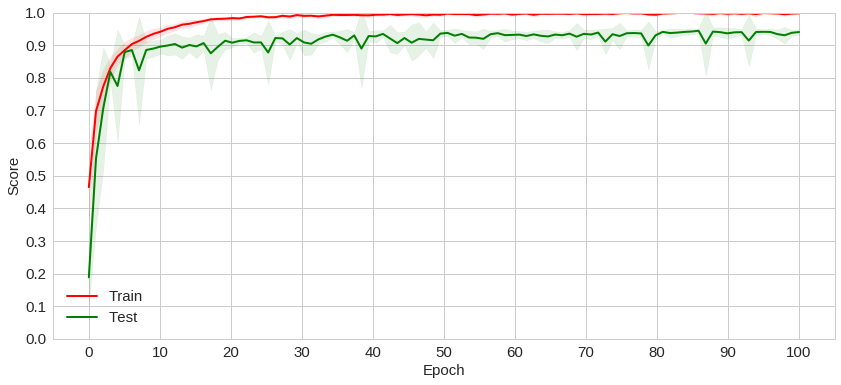

In [33]:
plot_mean_acc(history)

In [34]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

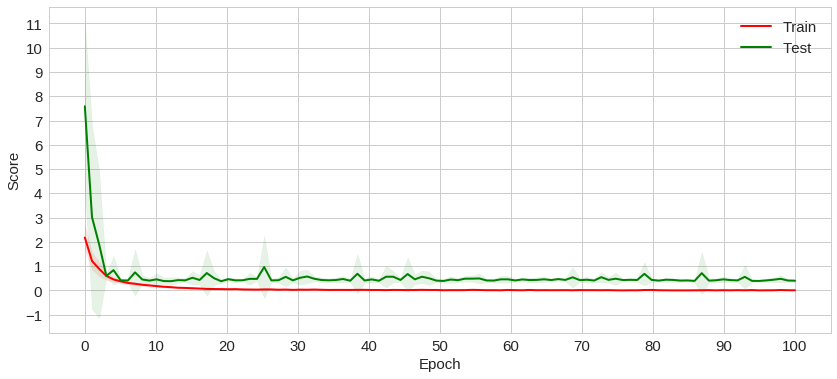

In [35]:
plot_mean_loss(history)

In [5]:
history = [{'val_loss': [3.0220468826591969, 0.79052748840973663, 0.73037212951444985, 0.78740206293866777, 0.34598728296890435, 0.40923154429834518, 0.66431384989891074, 0.6722128156116014, 0.82559703503294601, 0.53919850600511232, 0.77990151298126875, 0.49018417049856211, 0.85405932083085645, 0.51012042411116543, 0.4284481474445565, 0.55901569145953811, 0.48016540690114606, 0.46286640861612449, 1.0786678532051619, 0.46017416946012624, 0.47615901212545753, 0.61061800489754514, 0.37084715929854317, 0.45347396351006442, 0.47414150080525674, 0.37638747834166342, 0.54626201814774422, 0.48523566779468741, 0.51627867480856349, 0.52684410791886238, 0.35544470175211362, 0.63262119308928932, 0.59143634805746315, 0.60590715933927042, 0.43193329079697262, 0.4402053672140771, 0.44271852862354599, 0.38815801969804342, 0.40477659005522115, 0.39704323567439381, 0.77399826781828551, 0.51330829361183472, 0.46513413935572556, 1.0236011521518815, 0.59393633191230855, 0.39630039844058684, 0.42900992516008296, 0.58052073243953783, 0.53095206311853627, 0.43176349374394896, 0.43550702285553866, 0.45550261421506599, 0.42690182520728204, 0.66510983326634499, 0.63214167963923318, 0.4768095685978655, 0.45106128670520818, 0.43036780388020413, 0.5700889390052617, 0.5853302076564022, 0.47537309023567875, 0.39729301423992069, 0.43654958409765943, 0.4005574672339951, 0.38340053852008227, 0.38577413400051164, 0.39247846514413265, 0.4605221677776572, 1.790021551000339, 0.45923178827323063, 0.44914223100066186, 0.42808859836927526, 0.42168640128748613, 0.42504122016696977, 1.2235623883399431, 0.56077304651069904, 0.6341989335962297, 0.41919379685361458, 0.40642369426628999, 0.39293448293864808, 0.38425293519888193, 0.42856438385512474, 0.42239141039361616, 0.42201646025189632, 0.42293941130659141, 0.43090801503842746, 3.2954617533250725, 0.43007790472954532, 0.40689701747670881, 0.39367009547799059, 0.42155648631480691, 0.45181599711733078, 0.44654466441782992, 0.44744885271436896, 0.45122290004421561, 0.54059795124301813, 0.52017777379290164, 0.44665902374798838, 0.4558611855988679, 0.38975795337800445], 'val_acc': [0.0849609375, 0.787109375, 0.8330078125, 0.7822265625, 0.9111328125, 0.9111328125, 0.85546875, 0.841796875, 0.8388671875, 0.8798828125, 0.875, 0.9052734375, 0.8115234375, 0.9130859375, 0.921875, 0.89453125, 0.904296875, 0.921875, 0.822265625, 0.9208984375, 0.9111328125, 0.908203125, 0.931640625, 0.912109375, 0.9267578125, 0.9375, 0.9189453125, 0.9130859375, 0.91015625, 0.908203125, 0.927734375, 0.8955078125, 0.908203125, 0.90625, 0.9296875, 0.9384765625, 0.935546875, 0.9404296875, 0.931640625, 0.9384765625, 0.890625, 0.923828125, 0.92578125, 0.8486328125, 0.912109375, 0.9326171875, 0.935546875, 0.9208984375, 0.9306640625, 0.931640625, 0.943359375, 0.9404296875, 0.94140625, 0.90625, 0.8994140625, 0.9287109375, 0.9306640625, 0.9404296875, 0.92578125, 0.9140625, 0.91796875, 0.93359375, 0.935546875, 0.9326171875, 0.9462890625, 0.9423828125, 0.943359375, 0.9443359375, 0.8017578125, 0.9326171875, 0.93359375, 0.939453125, 0.9443359375, 0.9384765625, 0.80859375, 0.9228515625, 0.9091796875, 0.9228515625, 0.9306640625, 0.939453125, 0.9365234375, 0.9345703125, 0.9326171875, 0.935546875, 0.935546875, 0.9375, 0.611328125, 0.9296875, 0.9345703125, 0.939453125, 0.9384765625, 0.935546875, 0.93359375, 0.9306640625, 0.935546875, 0.923828125, 0.912109375, 0.927734375, 0.931640625, 0.9345703125], 'loss': [0.86561160452853603, 0.45840523561382629, 0.34623337430426487, 0.2692052850645294, 0.21715580896720538, 0.15618462779962305, 0.14379286042907657, 0.13164810271552643, 0.10010886555243222, 0.075531023922045179, 0.091437959213617651, 0.071256266557509315, 0.080270621589326921, 0.056373069310377666, 0.037413304032229665, 0.066995672596952965, 0.052579043429595101, 0.034740345854282748, 0.042718506527838117, 0.050902410291731801, 0.048209852723029044, 0.032136970665012005, 0.024375287759100611, 0.032638682735104403, 0.036175359276089003, 0.025099762527393377, 0.029851854667214708, 0.029352649734961222, 0.038180450327171926, 0.014518184084430417, 0.026496369478135259, 0.01030404504618514, 0.043105122581199216, 0.035865772174338298, 0.015133298615989355, 0.041815903016578247, 0.020943443615841578, 0.014457206235831245, 0.002753421550837801, 0.00111809915044362, 0.031317125221929906, 0.042419496229230372, 0.010243279980150875, 0.0076680580533556968, 0.047318538523477185, 0.011428514296033964, 0.0026158619902113462, 0.0063508140747628337, 0.023376428510163302, 0.044995215117709167, 0.006042974568772415, 0.003817570669414602, 0.0026373983702487158, 0.010845549360577307, 0.048212711977332866, 0.012493416220528861, 0.0065734158161113295, 0.0017923036428334875, 0.0075234742050946475, 0.03030756571831986, 0.021430443275122064, 0.013934663657131115, 0.0039375978497668326, 0.0045978296469128248, 0.0013480356736866536, 0.00075460632573011216, 0.00066086465637256214, 0.0015497567984341645, 0.02457338323679056, 0.056727373451719659, 0.014244309806872718, 0.0033989398809419064, 0.0010772729193720173, 0.0013369407697974177, 0.0014765139783996237, 0.01178639488798972, 0.025957918591750548, 0.021133882137989439, 0.0078163798784104885, 0.0025494072903765141, 0.0011991342447216274, 0.0014609838770593502, 0.00075250043230389019, 0.00059875349251269745, 0.00066796301916399097, 0.00064460376122429236, 0.0063471845389961815, 0.073907330266367727, 0.0081246287174014855, 0.0021561989479315941, 0.001211334271775302, 0.0010303901106438278, 0.00081475247373552972, 0.001903382005357655, 0.0022040818630004659, 0.039324961957653476, 0.022268310780174345, 0.0075333898863380192, 0.0073209440544249813, 0.001865361538117154], 'acc': [0.7458296752583049, 0.86106233548657529, 0.89420544342370911, 0.91780070247516177, 0.9308604038630377, 0.95204126431923142, 0.95577260765514427, 0.95687006150974951, 0.96806409141282646, 0.97618525032415215, 0.96905179982440737, 0.97750219490781387, 0.97410008790097391, 0.98331870061457416, 0.98715978928884984, 0.97695346805900729, 0.98035557506584725, 0.98891571553994728, 0.98562335381913957, 0.98397717306339705, 0.98441615462617149, 0.99045215100965756, 0.99143985952589986, 0.98880597025391515, 0.98968393327480242, 0.99143985952589986, 0.99023266033293178, 0.99111062335381916, 0.98726953467954348, 0.99593942054433715, 0.9915496049165935, 0.99703687445127309, 0.98683055316909973, 0.98836698858647942, 0.99550043898156282, 0.98792800702370498, 0.99374451273046527, 0.99659789288849865, 0.99912203687445122, 0.99978050921861283, 0.99056189640035119, 0.98650131694468834, 0.99703687445127309, 0.99780509218612823, 0.98814749780509215, 0.99626865671641796, 0.99945127304653203, 0.99835381924425748, 0.99209833197472286, 0.98661106233538187, 0.99802458296751539, 0.99846356453028973, 0.99923178226514486, 0.99780509218612823, 0.9840869183494293, 0.99692712906057945, 0.99780509218612823, 0.9996707638279192, 0.99835381913959609, 0.990891132572432, 0.99341527666304585, 0.99615891132572432, 0.9990122914837577, 0.99835381913959609, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99473222124670768, 0.98178226514486389, 0.99517120280948201, 0.9990122914837577, 0.99989025460930636, 0.99956101843722567, 0.9996707638279192, 0.99626865671641796, 0.99198858658402922, 0.99264705882352944, 0.99758560140474095, 0.99956101843722567, 0.99978050921861283, 0.9996707638279192, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99879280070237053, 0.97914837576821778, 0.99791483757682176, 0.99945127304653203, 0.99978050921861283, 0.99978050921861283, 0.99978050921861283, 0.99945127304653203, 0.9993415276558385, 0.99001316944688322, 0.99341527655838457, 0.99747585601404742, 0.99780509218612823, 0.99945127304653203]},
{'val_loss': [10.735767982244026, 0.89020306633059998, 2.332778540142828, 0.54556910188070362, 0.75868791043248074, 0.46171181760509655, 0.41924296908532571, 0.52239898014121089, 0.30397800437982125, 0.34070528982072312, 0.34814309617121741, 0.32473538527101159, 0.30319330114880377, 0.38306570330857065, 0.39017266626314873, 1.1176480897380483, 0.35291823651329068, 3.5045558726581274, 0.28639398787957532, 0.28931593732371635, 0.56975426927079953, 0.31515743783306066, 0.42903208694160588, 0.41836923971481044, 0.3865038084075319, 1.6035677171702474, 0.32970086622047251, 0.42185569310428345, 1.7018718247482696, 0.30788679656589918, 0.33999994905113423, 0.50756433109517385, 0.54940656128515541, 0.40820694254437206, 0.45241702386515803, 0.51732832769752568, 0.33651533009342421, 0.36153746505666268, 0.37286767676791782, 0.33781446273591881, 0.58941399024177932, 0.27098871439727845, 0.39449668943947253, 0.74896611784951672, 0.44927050151802306, 0.34991903689855813, 0.39232898685416145, 1.2833691923492889, 0.33328139970400006, 0.34033719702851972, 0.34694824347529091, 0.43078732438960476, 0.40051319486208631, 0.59446731060259828, 0.40330975749469067, 0.40262547712524066, 0.33560610346431918, 0.42799401524533393, 0.4024746181117092, 0.34048618207394393, 0.35750370307516977, 0.47293846325046857, 0.3625019507042761, 0.36139489856147139, 0.36534901306155004, 0.50754074591106113, 0.48800433666870385, 0.32571844300521863, 0.34592767077970565, 0.35668432574261588, 0.34090743945631508, 0.33421167622941095, 0.84290188699070545, 0.38665280586635437, 0.419308917384769, 0.41186444794835353, 0.40013872877819323, 0.45363176059920673, 0.5365838434150213, 0.59104961209134366, 0.40064555709630489, 0.37778854040504695, 0.46546480733413126, 0.35984776370913862, 0.37291596463947468, 0.38761978946223785, 0.61518032590598026, 0.33551738682191073, 0.48332717768219297, 0.51832135201302232, 0.42242230152627164, 0.40011926868667474, 1.9964404812780885, 0.31729137798360985, 0.38294807302308259, 0.3589142699162598, 0.34434803156246468, 0.36650531298498412, 0.35067633743124083, 0.3689816568343372], 'val_acc': [0.11643835616438356, 0.7211350302873526, 0.42465753517972049, 0.83757338645173607, 0.79647749674063606, 0.86301369863013699, 0.86888454198370713, 0.83855186026623574, 0.90998043052837574, 0.89530332774332122, 0.8953033268101761, 0.90998043146152086, 0.91976516634050876, 0.89236790699968138, 0.90998043146152086, 0.83953033524716669, 0.92074364085486726, 0.54207436399217224, 0.92563600876093377, 0.93150684931506844, 0.89823874965339257, 0.91487279843444225, 0.91389432485322897, 0.92367906159850721, 0.91682974653001403, 0.83561643835616439, 0.92661448234214705, 0.90019569471624261, 0.77005870841487278, 0.93542074363992167, 0.93639921722113506, 0.90704500978473579, 0.90019569564938784, 0.91976516634050876, 0.92563600782778865, 0.89138943248532287, 0.9393346379647749, 0.92563600782778865, 0.94227005870841485, 0.92661448140900193, 0.89334637964774954, 0.95205479452054798, 0.93737769173549346, 0.87377691000641677, 0.90802348336594907, 0.94031311154598829, 0.94227005870841485, 0.86594912240649857, 0.93835616438356162, 0.94618395303326808, 0.94618395303326808, 0.92954990215264188, 0.9393346379647749, 0.8904109589041096, 0.93737769080234834, 0.92563600782778865, 0.9393346379647749, 0.93639921722113506, 0.93248532289628183, 0.94618395303326808, 0.9452054794520548, 0.92465753424657537, 0.93248532289628183, 0.94031311154598829, 0.94031311154598829, 0.91095890410958902, 0.92759295499021521, 0.95303326810176126, 0.94129158512720157, 0.94618395303326808, 0.94422700587084152, 0.94814090019569475, 0.85420743779893493, 0.93542074363992167, 0.94031311154598829, 0.92759295499021521, 0.94031311154598829, 0.9285714285714286, 0.9021526428118144, 0.90410958997424107, 0.94422700587084152, 0.94324853228962813, 0.93150684931506844, 0.94422700587084152, 0.94324853228962813, 0.94911937377690803, 0.9119373776908023, 0.94814090019569475, 0.93639921722113506, 0.93444227005870839, 0.94129158512720157, 0.94716242661448136, 0.6810176125244618, 0.94618395303326808, 0.94129158512720157, 0.9452054794520548, 0.94814090019569475, 0.94911937377690803, 0.9452054794520548, 0.94618395303326808], 'loss': [2.6136111728659004, 1.4668068461494539, 1.1226034479521072, 0.61114031597988261, 0.4577248743392931, 0.40536904000179114, 0.34382034735523193, 0.313714821557871, 0.27798764462651643, 0.25100724653818901, 0.22006234826815607, 0.18780684380879756, 0.16412788251852659, 0.14589640999035874, 0.12053890913129768, 0.1019510145227402, 0.096363016314287897, 0.068405090665474566, 0.072972538296704706, 0.058920004825882936, 0.051954947877368735, 0.050157057972809241, 0.041240451381669929, 0.042347721083325553, 0.030886044235691995, 0.047668178847015873, 0.042202799561167195, 0.017098992237821631, 0.072754220413798226, 0.036450539341779185, 0.021903978394514741, 0.019570501965099883, 0.023666427339588014, 0.034528563520528778, 0.024696151923192251, 0.040797110105115837, 0.017818017786378742, 0.02114185329026667, 0.01240526338612989, 0.012565683163185555, 0.036927255073858398, 0.0095999792067624577, 0.0087967252954780882, 0.024484830419421826, 0.02305050080806419, 0.0090694917734375127, 0.0059703216671893643, 0.030408208262454443, 0.038937073989152263, 0.020606421156927297, 0.0054365106798647681, 0.0086405511567538631, 0.014112407996288757, 0.019020532343668767, 0.01776387536984117, 0.013943013420653494, 0.013538280444025479, 0.003313046678638765, 0.0061827759354031245, 0.0032772959813558941, 0.0021087309731836271, 0.0023550103781750523, 0.066215579890716955, 0.015345040058539277, 0.0047097644393798987, 0.0050530076420338722, 0.016181324891736491, 0.012428854471287273, 0.0080446998506877119, 0.0029038616550226999, 0.0012100109861966375, 0.0010140351289180984, 0.010577047446427269, 0.048842276169967835, 0.0092182363096818074, 0.0040877333931969104, 0.0032286041107645468, 0.004069426525361579, 0.019827109405684794, 0.011578751973491444, 0.012015091930392163, 0.012917036112501475, 0.0092999932612326964, 0.0068723592829882671, 0.0013274828074741562, 0.0017158717050419344, 0.01122417540756528, 0.012157410878505324, 0.010476723442673447, 0.0062518277951924802, 0.0038765007388871695, 0.018527744454125729, 0.016765684346881839, 0.016296662056467289, 0.0073631650606857659, 0.002676463860342199, 0.0012698849302109109, 0.001311650284355827, 0.0012723186107705816, 0.0010051646995987416], 'acc': [0.38775510221085374, 0.66370419149783877, 0.72975641874883002, 0.81248628484959506, 0.85692341472329814, 0.87239411914717457, 0.89225367576845227, 0.90004388870626839, 0.91057713407943819, 0.919245117427959, 0.92506034681089144, 0.93921439552715213, 0.94557823147563425, 0.95260039499670834, 0.96071977179275936, 0.96763221417599299, 0.96927803379416277, 0.97662936160510538, 0.97509326311169631, 0.98156682027649766, 0.98376124652561614, 0.98189598420013169, 0.98858898398068906, 0.98507790212859336, 0.99023480359885885, 0.98189598429169023, 0.98694316436251917, 0.99440421348133967, 0.97586131235840079, 0.98836954136493305, 0.99407504937458857, 0.99363616423463519, 0.99363616414307654, 0.98858898398068906, 0.99297783638736725, 0.98683344305464116, 0.99473337722185651, 0.99319727891156462, 0.99615975422427039, 0.99561114768488035, 0.9876014922097871, 0.9972569673946089, 0.99670836076366032, 0.9930875577868038, 0.99220978714066277, 0.99780557384244017, 0.99824445907395221, 0.99001536098310294, 0.9876014922097871, 0.99385560675883255, 0.99802501645819619, 0.99670836076366032, 0.99528198385280497, 0.99418477068246658, 0.99539170506912444, 0.99572086899275836, 0.99572086899275836, 0.99890278692122014, 0.99846390168970811, 0.99912222953697605, 0.99934167215273206, 0.99912222953697605, 0.97948211542681585, 0.99572086899275836, 0.99890278692122014, 0.99879306561334213, 0.99605003291639238, 0.99670836076366032, 0.99780557384244017, 0.99912222953697605, 0.99978055738424398, 0.99978055738424398, 0.99758613122668427, 0.98496818091227401, 0.99692780337941633, 0.99868334430546413, 0.99923195084485406, 0.99890278692122014, 0.99462365609709569, 0.99572086899275836, 0.99615975422427039, 0.99517226245336843, 0.99714724599517224, 0.99791529515031818, 0.99978055738424398, 0.99956111476848808, 0.99714724599517224, 0.99583059030063636, 0.99572086899275836, 0.99802501645819619, 0.99879306561334213, 0.99451393460610049, 0.99528198376124644, 0.99550142637700245, 0.99802501645819619, 0.99923195084485406, 0.99967083607636598, 0.99945139346061007, 0.99967083607636598, 0.99978055738424398]},
{'val_loss': [7.5064129941603737, 13.871279346241671, 0.69811666520568083, 0.61574240630748223, 0.46330168326157056, 0.39909499512127072, 0.36365620269184457, 0.40398426323836156, 0.33896390902878276, 0.63846560326295299, 0.37101606054519271, 0.28063545910778226, 0.31169870058987653, 0.37873609006948988, 0.35441905260325918, 0.31737890186143924, 0.55853140569456361, 0.50663630279675853, 0.41753833176005051, 0.33013223313275164, 0.39725600966653385, 0.41208927334090928, 0.48806510143215914, 1.192158103998151, 0.55522263187133558, 0.41613571818953177, 0.36480471632338124, 0.67735537861601824, 0.38344519828351176, 0.43256709221994633, 0.44511642251609729, 0.40983597250935117, 0.54472021756941436, 0.4842878664103008, 0.36913296161110648, 0.49362854217220847, 0.7683723529898927, 0.39980430805238509, 0.43337114365163676, 0.3982823287135025, 0.44485777117289288, 0.39767913161795326, 1.8893449986088728, 0.33262004342755952, 0.47306890996254763, 0.43782526889455153, 0.404569911098974, 0.36196029495541621, 0.38185104772790546, 0.39500230283436338, 0.40007670019431091, 0.83580565792521, 0.3864358340948898, 0.37237088033154186, 0.38580436306977334, 0.39671984805280386, 0.39913699014971771, 0.49372896208045608, 0.38151503714212043, 0.37567192790613319, 0.38024573820354424, 0.40272103040777829, 0.37525753492033942, 0.41793893539893362, 0.44021165394748346, 0.4934947075571775, 0.41529988339373219, 0.51342416111897493, 0.42552632493549991, 0.41524196804402175, 0.43369813693588871, 0.44010348354856976, 0.33977992710781429, 0.37686346227623663, 0.37914119664036144, 0.38474650767637009, 0.39036691733196999, 0.39114561104399942, 0.68609833350938598, 0.43794823361301016, 0.45388333618615317, 0.43278587317905681, 0.42413497049666221, 0.46444618201593824, 0.5161236935396426, 0.43361154035342225, 0.47326552734503846, 0.45830604520611529, 0.55600026503841271, 0.40563899583093788, 0.40814250357357507, 0.39774989876380051, 0.34367955116715443, 0.39200338738891932, 0.37508847012252317, 0.39031309929563329, 0.38777552916152869, 0.38323661936270431, 0.38694300569743073, 0.38505197737154717], 'val_acc': [0.21568627455363087, 0.13725490196078433, 0.79019607983383477, 0.81764706022599165, 0.85882353034673953, 0.88823529411764701, 0.8950980396831737, 0.88921568674199725, 0.91470588235294115, 0.84019607983383482, 0.8862745107388964, 0.91960784360474235, 0.91568627591226615, 0.9000000004674874, 0.9147058837554034, 0.9274509803921569, 0.85490196218677594, 0.87647058870278149, 0.90392156956242575, 0.92843137301650702, 0.92450980438905606, 0.89803921568627454, 0.89803921615376192, 0.82156862885344262, 0.89705882493187394, 0.92058823576160509, 0.92941176564085715, 0.87352941223219327, 0.92450980485654344, 0.91372549066356579, 0.92352941176470593, 0.92352941316716808, 0.9117647068173278, 0.91568627591226615, 0.93725490289575908, 0.90784313818987683, 0.81666666760164153, 0.93627451073889634, 0.93137254995458263, 0.93137254995458263, 0.9284313734839944, 0.93431372689265835, 0.79803921615376194, 0.94117647152321016, 0.92156862838595521, 0.93333333426830811, 0.92941176517336976, 0.94901960831062471, 0.93823529458513444, 0.9421568632125854, 0.94607843184003648, 0.86862745238285444, 0.93529411904952109, 0.93921568674199718, 0.9421568632125854, 0.94019607889885992, 0.92941176517336976, 0.92450980485654344, 0.93725490289575908, 0.93823529505262193, 0.93137254995458263, 0.93921568674199718, 0.94117647058823528, 0.9284313734839944, 0.93431372642517085, 0.93725490289575908, 0.9352941185820336, 0.91764705975850425, 0.94117647152321016, 0.92058823576160509, 0.93725490289575908, 0.93627451073889634, 0.94705882446438661, 0.94509804015066112, 0.95000000093497483, 0.94803921662124935, 0.95196078524870031, 0.95000000093497483, 0.90196078524870027, 0.93235294117647061, 0.9352941185820336, 0.93725490289575908, 0.93725490289575908, 0.93529411811454621, 0.93725490289575908, 0.94509803968317363, 0.9254901965459188, 0.93235294211144537, 0.9117647068173278, 0.93823529505262193, 0.93921568720948467, 0.93823529505262193, 0.94509804015066112, 0.9421568636800729, 0.94509804015066112, 0.94607843230752386, 0.94705882446438661, 0.94705882446438661, 0.94607843230752386, 0.94705882446438661], 'loss': [2.4646954894745856, 1.6359296290693497, 0.90651728896102968, 0.61863485325214473, 0.51093570564388446, 0.41334981458550119, 0.35657424742896182, 0.3192030338144658, 0.24661559157462537, 0.26449127669212014, 0.20221342799589268, 0.15424696591279391, 0.1201681821472606, 0.10218710380967194, 0.093628444512321163, 0.076707945604526248, 0.059254919256836819, 0.05222850278372982, 0.052495766727367402, 0.056213988915180597, 0.040376164806482005, 0.049837925529292164, 0.03015167691483121, 0.020963690935538248, 0.026715442037660204, 0.053974038617666642, 0.029335580474460339, 0.026830516567063683, 0.029436361213036319, 0.030597183615372392, 0.031449253789483093, 0.035842256490280604, 0.03138825548872002, 0.012156951583583441, 0.014951905920111759, 0.014181152468397761, 0.037198443999334176, 0.014509762512275428, 0.022861448946238469, 0.018934261053110978, 0.015976242973833307, 0.015500334371425339, 0.03307337550951947, 0.015180165710580834, 0.016281692645861767, 0.035863724710520559, 0.011732002785953457, 0.0079383208808224952, 0.004707260658570381, 0.0036044756838501924, 0.002863411218664123, 0.040683781161418728, 0.037792039913605094, 0.012331062761931789, 0.0031119481742210749, 0.0051753186990661261, 0.011008196587942193, 0.015635433301928341, 0.021882109563976397, 0.017171722252417181, 0.010802360731337684, 0.0082478566763024754, 0.0050068047818232399, 0.0089253027519063544, 0.024900530419867575, 0.015102405401809495, 0.0068293090426658461, 0.0025863107327338689, 0.0048081071574412352, 0.018590128829374993, 0.019470171874683591, 0.016639216574559107, 0.0098308627568226958, 0.0025771887993533689, 0.0013653209262716834, 0.00092695058441966181, 0.00090924837705575411, 0.0010974703622528932, 0.027110032409926946, 0.024939856921532614, 0.0058309999999012407, 0.0067900554949805406, 0.0097040950551122787, 0.0065242765092274283, 0.011010189160726149, 0.0085568086641419142, 0.0066711812613950514, 0.005927705014833023, 0.012600906870483932, 0.0094958857784171128, 0.0082219505776836652, 0.0054056416197504264, 0.0012050337131565643, 0.0019199893713618154, 0.0012042994383859157, 0.00085285228705226062, 0.00081949184967422008, 0.00092277073340598921, 0.0007984933870463539, 0.00085407694766512015], 'acc': [0.40664765253146523, 0.64238701179499369, 0.75362000872347112, 0.82415533131180541, 0.85925844689637432, 0.88624396686127127, 0.90116279080228989, 0.91004826683598472, 0.92803861353155703, 0.92858709965739772, 0.9350592365595477, 0.94975866618623017, 0.9584247476963581, 0.96555506801228608, 0.96796840724844635, 0.97356296621325145, 0.98080298386942455, 0.98277753416306624, 0.98102237823606842, 0.98025449769127626, 0.98749451513821851, 0.98321632294866168, 0.99133391838525664, 0.99265028521281262, 0.99166301009214564, 0.98255813953488369, 0.99001755155770077, 0.99100482667836776, 0.99089512944273805, 0.99166301009214564, 0.99045634050021936, 0.98837209307556351, 0.99067573497147876, 0.99594120228170246, 0.99572180781044317, 0.99583150504607287, 0.98727512077157464, 0.99528301886792447, 0.99232119355823134, 0.99374725762141702, 0.99484422992540589, 0.99495392716103559, 0.98935936819623049, 0.99506362439666518, 0.99528301886792447, 0.98946906537955248, 0.99648968845985086, 0.99747696358051774, 0.99879333040807372, 0.99890302764370342, 0.99945151382185171, 0.98760421242615593, 0.98815269860430421, 0.99605089951733217, 0.99945151382185171, 0.99846423870118473, 0.99692847740236945, 0.99517332173691031, 0.99243089074155333, 0.99451513821851689, 0.99703817463799915, 0.99791575252303644, 0.99824484428223315, 0.99681878016673975, 0.99166301009214564, 0.99539271610355418, 0.99769635805177714, 0.99956121110978902, 0.99890302764370342, 0.9941860465116279, 0.99374725756910931, 0.9942957437472576, 0.99725756910925845, 0.99912242211496272, 0.9995612110574813, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99177270738008305, 0.99254058797718292, 0.99846423870118473, 0.99813514699429573, 0.99637999122422116, 0.99780605528740673, 0.99670908293111016, 0.99780605528740673, 0.99780605528740673, 0.99769635805177714, 0.99670908293111016, 0.99736726634488815, 0.99747696358051774, 0.99813514699429573, 0.999670908293111, 0.9995612110574813, 0.999670908293111, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071]},
{'val_loss': [13.713657916061521, 0.9471889260988563, 0.79109387580070678, 0.58127033083853641, 0.56684067884672085, 0.45605255902733832, 0.49407113356793109, 0.45455911240166219, 0.44334244376917437, 0.42803219962965028, 0.4019182825527029, 0.40178751373777211, 0.41237820034863298, 0.46744447036028253, 0.49616331227329868, 0.97601670474771918, 0.37579740920263582, 0.41577848929068034, 0.40105761640820209, 0.41641456767840146, 0.46090561513300793, 0.51907895592464803, 0.49107313785986667, 0.42894021763251344, 0.46843294202218083, 4.6314298084196484, 0.45402589153230105, 0.49390829406253017, 0.46848873598358076, 0.51664063374517888, 0.45233259248905777, 0.54394080796446642, 0.61121170578653838, 0.48642496544532804, 0.62426886982324159, 0.66260895805249753, 0.57229854016896564, 0.52017507819734932, 0.49012293169034621, 0.47718707843045211, 0.44637975213596548, 0.45319602636128609, 0.49769514817721638, 0.83676373882881883, 0.44152712252808646, 2.7159534455254466, 0.58827562139658252, 0.67245376560624825, 0.50644153965700611, 0.53312497419575433, 0.56846373939706285, 0.53968682929292877, 0.50009380932871372, 0.57214852419331252, 0.52670492115755263, 0.60031759344750379, 0.54101441064785227, 0.58776928398058215, 0.57515036070826075, 0.58143474378446702, 0.48427441928277398, 0.48563246310050984, 0.67279280824921328, 0.53460548187013901, 0.53071474175872735, 0.47850584791022072, 0.57598222061514792, 0.52102943336675511, 0.50599288190746317, 0.60660019931362952, 0.74731995194304535, 0.50844983919026832, 0.51973027347026468, 0.4735476135061818, 0.50876288551350535, 0.46114201700277851, 0.48188612847184142, 0.63456700057393156, 0.82551034500040299, 0.51046266126849593, 0.51278882884782417, 0.57446125933986114, 0.62090335073517022, 0.553066981344988, 0.51762505605805464, 0.50908689204173008, 0.5553920377735122, 0.67507276702150731, 0.54347531239767521, 0.50011492024854198, 0.59506483264507248, 0.53021492629218492, 0.60603392100127729, 0.54800862930935001, 0.51515534838709731, 0.54275423529835065, 0.63997295910668284, 0.61447215468294281, 0.55824284295556481, 0.56020641423187967], 'val_acc': [0.12106299212598425, 0.7244094497575535, 0.76476377999688694, 0.81692913385826771, 0.85433070866141736, 0.86614173228346458, 0.85728346456692917, 0.8917322834645669, 0.87598425196850394, 0.89468503937007871, 0.89370078787090268, 0.88976377952755903, 0.89763779574491842, 0.88681102362204722, 0.88681102362204722, 0.82086614173228345, 0.90944881936696575, 0.9163385831464933, 0.91437007920948543, 0.91141732283464572, 0.9133858272409815, 0.90157480314960625, 0.90649606299212604, 0.91437007920948543, 0.90452755905511806, 0.59842519731972166, 0.91437007874015752, 0.91240157480314965, 0.90748031496062997, 0.89665354377641449, 0.91830708661417326, 0.90354330708661412, 0.90157480408826207, 0.9192913385826772, 0.90944881889763785, 0.88484251968503935, 0.90551181149295001, 0.90748031496062997, 0.91338582677165359, 0.92716535480003659, 0.92421259842519687, 0.92421259842519687, 0.92027559102050904, 0.86417322834645671, 0.91830708661417326, 0.76870078740157477, 0.90748031589928579, 0.88090551228035152, 0.9163385831464933, 0.92125984251968507, 0.91240157480314965, 0.91830708661417326, 0.92716535480003659, 0.90354330755594203, 0.90846456692913391, 0.90944881889763785, 0.90944881889763785, 0.91732283511499724, 0.91437007874015752, 0.91437007920948543, 0.922244094488189, 0.92913385826771655, 0.90157480361893416, 0.922244094488189, 0.92027559102050904, 0.92125984298901298, 0.91535433070866146, 0.92322834645669294, 0.92125984251968507, 0.91240157480314965, 0.89960629921259838, 0.91633858267716539, 0.92125984298901298, 0.93208661417322836, 0.9192913385826772, 0.93011811023622049, 0.93307086614173229, 0.91633858267716539, 0.89271653590239874, 0.92421259889452478, 0.9301181107055484, 0.91437007920948543, 0.91043307086614178, 0.92027559055118113, 0.922244094488189, 0.92716535433070868, 0.91830708661417326, 0.91338582677165359, 0.91732283464566933, 0.93503937007874016, 0.91437007874015752, 0.92125984251968507, 0.91240157480314965, 0.91830708661417326, 0.92421259842519687, 0.92618110236220474, 0.92125984251968507, 0.92618110236220474, 0.92421259842519687, 0.9192913385826772], 'loss': [2.2186734494410065, 1.1860653118083351, 0.72078625889200909, 0.53563837246936663, 0.44286239327568755, 0.37682764487046944, 0.32678452602081132, 0.30356825820186684, 0.23920515882864332, 0.21174884907117014, 0.18510055106721426, 0.16180035353621894, 0.13468651478423885, 0.11489827926352358, 0.0956545600357155, 0.092890772444048988, 0.083448459267648947, 0.056720212154629593, 0.054394651382748987, 0.050422451070820294, 0.042437837856184497, 0.04901217016138202, 0.040109591756277437, 0.050566295658344439, 0.029295062656890143, 0.04186025082578948, 0.056804080990045087, 0.020344880779106334, 0.027867856427410357, 0.013599195233709588, 0.010621841686671567, 0.03401991606147739, 0.052348362762080672, 0.016067997553220362, 0.012306156024115217, 0.025725263977674013, 0.03245155703803073, 0.017338640141232438, 0.032030540455404356, 0.02232254335242926, 0.010039369145510646, 0.011679595165607456, 0.0080583566875008592, 0.023812275453600339, 0.0082980405923112899, 0.010808792352946241, 0.018754272601743872, 0.022369763608858513, 0.011987758730180775, 0.010498560874403713, 0.0077683523345241845, 0.023345807943150519, 0.011909527393627765, 0.022110918800057045, 0.013671729876165174, 0.017628612748121029, 0.017292628047758433, 0.012300253521575462, 0.0089278241210067472, 0.013355819503429525, 0.011189461099539793, 0.0053778154651234599, 0.020415515059715273, 0.017781037200505747, 0.0062118897966340963, 0.01014814162541019, 0.012151150780680423, 0.0043263937673496877, 0.0013781187518497175, 0.0017629519734599166, 0.028132102377563379, 0.028919401241498572, 0.0079592110851910806, 0.0052375409151576794, 0.0020784710900937954, 0.0014234078261795315, 0.0011180697512013706, 0.003341350357149359, 0.023865951657533739, 0.018174083646916091, 0.0070109397765822663, 0.012867644422796505, 0.0040474992645533605, 0.0076100141016035303, 0.0036037832586739487, 0.0055530870261862762, 0.0034633332345191648, 0.019551669652559722, 0.012764124000042948, 0.0045800413065160426, 0.0019789997980425547, 0.0086101222144885758, 0.015044467492292537, 0.010102266936109229, 0.0025259426819853586, 0.002008969335743291, 0.0094292823852412232, 0.015645399808119308, 0.0058979222897234422, 0.0076088136177294508], 'acc': [0.46348684210526314, 0.67324561403508776, 0.78366228070175437, 0.83432017543859649, 0.86195175438596494, 0.88234649122807018, 0.89265350877192984, 0.9040570175438597, 0.92138157894736838, 0.93475877192982459, 0.93782894736842104, 0.94649122807017538, 0.95416666666666672, 0.96107456140350878, 0.97039473684210531, 0.97039473684210531, 0.97269736842105259, 0.98245614035087714, 0.98289473684210527, 0.98377192982456141, 0.98585526315789473, 0.98464912280701755, 0.98739035087719296, 0.98519736842105265, 0.99089912280701753, 0.98760964912280702, 0.98146929824561402, 0.993859649122807, 0.98991228070175441, 0.99572368421052626, 0.99714912280701751, 0.9888157894736842, 0.98234649122807016, 0.99484649122807023, 0.99594298245614032, 0.99013157894736847, 0.98958333333333337, 0.99396929824561409, 0.99035087719298243, 0.99265350877192982, 0.99725877192982459, 0.99616228070175439, 0.99747807017543855, 0.99276315789473679, 0.99769736842105261, 0.99682017543859647, 0.99396929824561409, 0.99177631578947367, 0.99682017543859647, 0.99671052631578949, 0.99725877192982459, 0.99243421052631575, 0.99671052631578949, 0.99342105263157898, 0.99561403508771928, 0.99473684210526314, 0.9944078947368421, 0.99561403508771928, 0.99725877192982459, 0.99572368421052626, 0.99605263157894741, 0.99813596491228074, 0.99298245614035086, 0.99451754385964908, 0.99846491228070178, 0.99725877192982459, 0.99616228070175439, 0.99857456140350875, 0.99956140350877198, 0.9994517543859649, 0.99177631578947367, 0.99024122807017545, 0.99802631578947365, 0.99879385964912282, 0.99934210526315792, 0.99967105263157896, 0.99978070175438594, 0.99901315789473688, 0.99276315789473679, 0.99484649122807023, 0.99791666666666667, 0.9966008771929824, 0.99879385964912282, 0.99802631578947365, 0.99857456140350875, 0.99857456140350875, 0.99901315789473688, 0.99364035087719293, 0.99594298245614032, 0.99890350877192979, 0.99967105263157896, 0.9978070175438597, 0.99517543859649127, 0.99682017543859647, 0.9994517543859649, 0.99934210526315792, 0.99638157894736845, 0.99484649122807023, 0.99824561403508771, 0.99703947368421053]},
{'val_loss': [4.4249362865770898, 1.4142935308884448, 0.53306155546025669, 0.55926571993888763, 0.98148728871908708, 0.37926658798657564, 0.42726980154971061, 3.5666903592939452, 0.46556184444609816, 0.31156938412227536, 1.0644627930560229, 0.7411853731600978, 0.31733345696271431, 0.3336652950857103, 0.56797713199703936, 0.38464570975628071, 0.95161334485540527, 0.53137728045628074, 1.0469137889926146, 0.43912385835215723, 0.52385628392679739, 0.40481654654533888, 0.35391922474952203, 0.36238629569120312, 0.46738522507781755, 0.37508090343736533, 0.56451055377520942, 0.39739881419176631, 0.48667598671019058, 0.47273027812961554, 0.65914511535473586, 1.2796671636986197, 0.55450016830363036, 0.57028355283708287, 0.33834263869936076, 0.38915206449250245, 0.37892848955777758, 0.37528068510807305, 3.100817465717002, 0.38247161723961115, 0.41025903319631846, 0.40188813575852422, 0.374691856617545, 0.5161292342903151, 0.54645987845397948, 0.53346710240085182, 0.34155662848042168, 0.42222856689790517, 1.2935854589463922, 0.48448773069567752, 0.36962386831468247, 0.35578973287258481, 0.3578417167422836, 0.51737470013806586, 0.76882239453575596, 1.058973182950331, 0.46957322236158783, 0.33912607091813007, 0.45308904762187668, 0.77805043960350972, 0.44613014421221586, 0.66874176494025672, 0.43608308051765771, 0.69122174095074562, 0.77877369187254142, 0.45313320532233048, 0.49288592314110069, 0.51254585459252044, 0.4537600424947878, 0.37922557053908046, 0.47923079892804948, 0.53048333902206679, 0.90171639890640309, 0.41041540627499734, 0.42296961486950002, 0.43795070203330311, 0.40811251612380223, 0.39907408493456437, 0.68458652470178993, 0.41170414732469929, 0.42537840482729716, 0.38346811650995022, 0.43748274750733407, 0.38119897487135673, 0.37340680258764058, 0.37590070023483757, 0.37207070935820963, 0.38245088278632006, 0.37779152212595196, 0.7818531823653001, 0.45305711497965695, 0.34367956727827836, 0.36446768252092243, 0.39715210865138956, 0.39240030391297481, 0.39631019856562139, 0.5380872859005098, 0.40596197977520132, 0.37185847370077935, 0.42311744947782637], 'val_acc': [0.20177165354330709, 0.46259842566617831, 0.83070866235597862, 0.83267716582365858, 0.70275590645046682, 0.90059055165043023, 0.888779528028383, 0.33366141732283466, 0.8858267721228712, 0.92125984298901298, 0.85236220566306531, 0.82775590598113891, 0.91929133905200511, 0.9301181107055484, 0.85925196897326495, 0.91929133905200511, 0.87401574803149606, 0.90354330755594203, 0.82283464613861923, 0.90846456739846182, 0.88976377999688694, 0.91043307133546969, 0.91929133905200511, 0.92421259842519687, 0.91240157527247756, 0.92618110283153265, 0.90748031589928579, 0.93208661464255627, 0.8858267721228712, 0.9163385831464933, 0.86318897637795278, 0.82874015794964284, 0.91141732330397363, 0.90649606346145395, 0.93799212645357988, 0.93700787448507594, 0.94586614220161136, 0.94685039417011529, 0.52952755952444597, 0.93208661464255627, 0.94389763826460349, 0.93503937054806807, 0.94685039417011529, 0.90452755952444597, 0.87500000046932791, 0.92125984298901298, 0.94389763826460349, 0.93700787448507594, 0.75295275637483972, 0.91732283511499724, 0.93996063039058775, 0.94685039417011529, 0.95078740204413104, 0.93208661464255627, 0.88681102409137513, 0.83169291385515465, 0.9330708666110602, 0.94783464613861923, 0.93996063039058775, 0.90748031542995788, 0.92814960676854052, 0.89370078787090268, 0.93503937054806807, 0.88484252015436726, 0.87106299306464008, 0.93208661464255627, 0.91830708708350117, 0.92322834692602085, 0.93897637842208381, 0.94783464613861923, 0.93897637842208381, 0.92519685086302872, 0.85728346503625708, 0.93700787448507594, 0.94685039417011529, 0.93700787448507594, 0.93799212645357988, 0.94094488235909168, 0.91043307133546969, 0.9330708666110602, 0.94488189023310742, 0.95275590598113891, 0.9498031500756271, 0.95472440991814678, 0.95374015794964284, 0.95472440991814678, 0.95570866188665071, 0.95570866188665071, 0.95669291385515465, 0.89271653590239874, 0.92322834692602085, 0.94685039417011529, 0.9498031500756271, 0.95275590598113891, 0.94192913432759562, 0.95177165401263497, 0.91043307133546969, 0.94192913432759562, 0.93897637842208381, 0.93700787448507594], 'loss': [1.9650281962595488, 0.96149090376862312, 0.63802777324852189, 0.51953543181482109, 0.41391705630118386, 0.33553513947286107, 0.26805569925590567, 0.23877400506222457, 0.21186655164745294, 0.17490875273942946, 0.14850886252120529, 0.11243553986413438, 0.10021678224418377, 0.082184943456505011, 0.070738518150654017, 0.077668903215804649, 0.059844878566729133, 0.074055856743239265, 0.041708040647382295, 0.044013311243166722, 0.026693587528496751, 0.057648182422302567, 0.042796084474416844, 0.031625800229059614, 0.025667442832261595, 0.03146926929062159, 0.042814801600092836, 0.033459914080428955, 0.014216532942015889, 0.018396204998083577, 0.060918093784308888, 0.040494884085165453, 0.034777656297228531, 0.02256940006027754, 0.0078827396155375339, 0.003837893997732815, 0.0020431552122098556, 0.0018802349943837868, 0.029877469036874941, 0.069270998330830474, 0.024403116702109273, 0.0067437572685153822, 0.012323951478646721, 0.052980153300884188, 0.022652549911763024, 0.0087422952570162579, 0.0086354415871538921, 0.0036250162317660478, 0.020182229258147059, 0.052257285981715793, 0.010595178188582634, 0.0039913398516330887, 0.0023328460671851454, 0.0042381359413778694, 0.030724470420647233, 0.030803198234028523, 0.013243975008364878, 0.0067172083473252047, 0.0040979480886255519, 0.014935444169005725, 0.037232005188426433, 0.010541175519676727, 0.0058527848236528306, 0.011665509802297859, 0.015249248302318033, 0.016667530155997444, 0.0090440189909793585, 0.013975248129192328, 0.011576051043714853, 0.0047705991989021226, 0.0038583280834716374, 0.021758762479346747, 0.014187452526319951, 0.020639880193690865, 0.0054811760046656367, 0.0050911190331876964, 0.0097320472299894361, 0.0036648607957854356, 0.019444069160852194, 0.019747183112664508, 0.0082717436740981694, 0.0034295801050224358, 0.0016726640892130219, 0.0010521186808685806, 0.00087174056601976478, 0.00068892471577013115, 0.00087732608729245505, 0.00081933623912855066, 0.00093285520769255891, 0.052676257960365146, 0.034787337820652235, 0.0081440143608696204, 0.0037192734268772479, 0.0066278436303156543, 0.0058602114981735403, 0.0056976923879753817, 0.012630470295069149, 0.021285844405046144, 0.0045641690353812395, 0.010470238001786975], 'acc': [0.45307017543859651, 0.72138157894736843, 0.81425438596491229, 0.85175438596491226, 0.87752192982456145, 0.90021929824561409, 0.92094298245614037, 0.9291666666666667, 0.93563596491228074, 0.94473684210526321, 0.95504385964912286, 0.96392543859649127, 0.9665570175438597, 0.97291666666666665, 0.97631578947368425, 0.97521929824561404, 0.98223684210526319, 0.97587719298245612, 0.98684210526315785, 0.98530701754385963, 0.99067982456140347, 0.98168859649122808, 0.98651315789473681, 0.99002192982456139, 0.9922149122807018, 0.98980263157894732, 0.98475877192982453, 0.98859649122807014, 0.99561403508771928, 0.993859649122807, 0.98256578947368423, 0.987719298245614, 0.98947368421052628, 0.99232456140350878, 0.99791666666666667, 0.99890350877192979, 0.9994517543859649, 0.9994517543859649, 0.99057017543859649, 0.97642543859649122, 0.99232456140350878, 0.99802631578947365, 0.99627192982456136, 0.98355263157894735, 0.99342105263157898, 0.99736842105263157, 0.99671052631578949, 0.99890350877192979, 0.99342105263157898, 0.98421052631578942, 0.99649122807017543, 0.99901315789473688, 0.99956140350877198, 0.99890350877192979, 0.99089912280701753, 0.99024122807017545, 0.99605263157894741, 0.99802631578947365, 0.99824561403508771, 0.99594298245614032, 0.98837719298245619, 0.99649122807017543, 0.99813596491228074, 0.99627192982456136, 0.99506578947368418, 0.99451754385964908, 0.99703947368421053, 0.99462719298245617, 0.99627192982456136, 0.99813596491228074, 0.99868421052631584, 0.99353070175438596, 0.99605263157894741, 0.99342105263157898, 0.99835526315789469, 0.99879385964912282, 0.99649122807017543, 0.99912280701754386, 0.99353070175438596, 0.99396929824561409, 0.99725877192982459, 0.99868421052631584, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99956140350877198, 0.99978070175438594, 0.99978070175438594, 0.98629385964912286, 0.98903508771929827, 0.99736842105263157, 0.99901315789473688, 0.99824561403508771, 0.99879385964912282, 0.99857456140350875, 0.99539473684210522, 0.99353070175438596, 0.99846491228070178, 0.99671052631578949]},
{'val_loss': [10.062018194491031, 0.81817871346907611, 0.55564423174432431, 0.56072068601223968, 1.0511366007545582, 0.49080810950042791, 0.39459730685194799, 0.35304476364885812, 0.37117648972833989, 0.3792880067312086, 0.34296842090763757, 0.3258029004977141, 0.37581436092224668, 0.36980288477573475, 0.38286550019314292, 0.34641994548238159, 0.32280122489378699, 0.36333660123636946, 0.36175572169989495, 0.38017869492713724, 0.42495970135581385, 0.3938741827892423, 0.4602262606286065, 0.3931484763371475, 0.52860730496619512, 0.44200774418012007, 0.3718919488329096, 0.41051998901606879, 0.44693284822166524, 0.42291519046414289, 1.3566883940245731, 0.5562438078337093, 0.49582189109663433, 0.40524521950219083, 0.44308023434195848, 0.40179067476961994, 0.5823516648906778, 0.43594258352556448, 0.37611817511589923, 0.5737179009931539, 0.47186819385667528, 0.48800348659050419, 0.45870603280534872, 0.45316949973839943, 0.46284077646161531, 0.50289996397155756, 0.40046219795840265, 0.50606484805090013, 0.42182894353393269, 0.46158738300361724, 0.43654785567350324, 0.40739606976115966, 0.4414081794778979, 0.62921681347965386, 0.41895268752233644, 0.42139980239964409, 0.42296004595815362, 0.3908788270701225, 0.39901526618519995, 0.38799487940290289, 0.45999317722270877, 0.47814031373254118, 0.46472211450948353, 0.44866922363801764, 0.45462856568705418, 0.4441265035172412, 0.46076172304349733, 0.42269707668062756, 0.39631772634796142, 0.41591943904084311, 0.52939344464160587, 0.4518502462013182, 0.43835087954191621, 0.47132569742112962, 0.3629729576554041, 0.42872026741086683, 0.4343227977311529, 0.42305440273129508, 0.48100257271669672, 0.42531489403270278, 0.42789743873609498, 0.46247025611811382, 0.42387867629243409, 0.41751964094264238, 0.41044418255327381, 0.40757436771394101, 0.41024285698230234, 0.406719705359676, 0.41997040373308669, 0.42696455005494172, 0.42754146872287757, 0.43081240606867161, 0.43891239382677766, 0.39093354160945887, 0.38280233709279182, 0.36740913391260327, 0.42414181664484929, 0.37307501012112465, 0.38683438571580586, 0.37225926703058532], 'val_acc': [0.19584569738833299, 0.73986152365700542, 0.82690405580339521, 0.82393669675295012, 0.76755687520718596, 0.84767556956920376, 0.88130563839488874, 0.89317507459666912, 0.90702275016541301, 0.88328387776185213, 0.90504451079844961, 0.91493570763326659, 0.90306627184417909, 0.9129574682663032, 0.89910979269755931, 0.92284866510112018, 0.91889218636719339, 0.91394658794978489, 0.91394658794978489, 0.92977250288549207, 0.92878338361470325, 0.92087042573415678, 0.9119683485828215, 0.92977250288549207, 0.90405539111496791, 0.91889218636719339, 0.92185954541763848, 0.93471810130290056, 0.92383778478460188, 0.92977250288549207, 0.80811078181724283, 0.90900098994506928, 0.9099901092158581, 0.93175074225245547, 0.94065281940379086, 0.93471810130290056, 0.9119683485828215, 0.93076162256897377, 0.93768546035334566, 0.91790306709640457, 0.92878338320201037, 0.91988130605067508, 0.9258160237388724, 0.93273986193593716, 0.92581602415156528, 0.92878338320201037, 0.93966369972030916, 0.92680514383504697, 0.93570722098638226, 0.93273986193593716, 0.92779426351852867, 0.93570722098638226, 0.93669634066986396, 0.89910979269755931, 0.93669634066986396, 0.94460929813771766, 0.93768546035334566, 0.93669634066986396, 0.94460929813771766, 0.94658753750468105, 0.92482690446808358, 0.92383778478460188, 0.93669634066986396, 0.93570722098638226, 0.93273986193593716, 0.92482690446808358, 0.93966369972030916, 0.94460929813771766, 0.94856577687164445, 0.94559841782119936, 0.9129574682663032, 0.93768546035334566, 0.93768546035334566, 0.93669634066986396, 0.94362017845423596, 0.93867458003682747, 0.94460929813771766, 0.94065281899109787, 0.93966369972030916, 0.93175074225245547, 0.94263105877075426, 0.94460929813771766, 0.94362017845423596, 0.94263105877075426, 0.94856577687164445, 0.94757665718816275, 0.94559841782119936, 0.94658753750468105, 0.94856577687164445, 0.94955489655512615, 0.95054401623860785, 0.94856577687164445, 0.95153313592208955, 0.94263105877075426, 0.94559841740850648, 0.94757665677546987, 0.93669634025717108, 0.94460929813771766, 0.94955489655512615, 0.95153313592208955], 'loss': [2.7862780824948663, 1.3162033361408809, 0.7714089065251285, 0.60193115656343221, 0.48626762809492136, 0.42645251312647781, 0.35415574564019292, 0.3108031618039902, 0.29159914603870207, 0.23667832403966826, 0.21846358198009125, 0.20007645642920716, 0.19153402746866827, 0.15478054836678179, 0.18482515211627909, 0.14971968128909804, 0.11474236550151486, 0.087401700822662007, 0.093844709523736608, 0.088974962999661497, 0.079691554554521218, 0.061854226923152192, 0.074785261837689021, 0.045711385545690784, 0.055515429628221959, 0.043105412587727585, 0.042267488522684735, 0.054070555326669184, 0.060505037512375071, 0.032413633931989538, 0.023881449629999187, 0.035933553327028064, 0.042419235249904735, 0.059863555131505611, 0.047369812662419797, 0.014854281398442203, 0.027572138756513594, 0.027362762994145695, 0.015669333678249218, 0.02810820170218916, 0.029044786170737386, 0.047756298211237336, 0.021247195550585039, 0.013555636336019083, 0.010691332353444846, 0.042851963890946074, 0.017243498029901761, 0.033593156685108601, 0.035201249730958256, 0.011565412537111863, 0.028705458907199999, 0.0078621512548041166, 0.0043646503444075306, 0.020095476863159455, 0.05465621208075485, 0.014635227041272765, 0.0097076216539501992, 0.055185198730801882, 0.0044941705525406214, 0.0035167903293606712, 0.0049912894897199593, 0.01999874284184117, 0.024252192647438751, 0.0064618462117975702, 0.018581078934138767, 0.015741829969550241, 0.012201969803564493, 0.038893951245889784, 0.003774255577602411, 0.0025573832501166131, 0.0061335356140139272, 0.054166148464890734, 0.0064574507045103494, 0.010914708395974953, 0.028155384754372938, 0.0056231259710557303, 0.005756959356015153, 0.004087394889210086, 0.017399125907506335, 0.028293139230892099, 0.0087615883918510974, 0.0025454816373514828, 0.0018928860649115673, 0.0025002219765917527, 0.0010678006726148066, 0.0011059559057961053, 0.00088083880208881193, 0.00084015269262464204, 0.001118073803525414, 0.0010491334353175934, 0.00084928046487218361, 0.00083285133662926235, 0.0008044977753200092, 0.098621482646906081, 0.012096780723384954, 0.0037695170524211165, 0.0068252237830446613, 0.037334802885405874, 0.006034259764904998, 0.014459634182273015], 'acc': [0.37906849315395091, 0.65391780822244405, 0.7674520547945205, 0.81895890411612104, 0.84975342466406623, 0.86936986302023067, 0.88635616438356168, 0.90027397261580377, 0.90695890410958901, 0.92263013699283336, 0.92964383561643837, 0.93413698630790187, 0.93753424657534246, 0.94783561643998915, 0.93917808219831289, 0.95002739726680596, 0.96208219178082188, 0.9716164383561644, 0.96723287671232872, 0.96887671232876715, 0.97172602739726033, 0.97873972602739723, 0.97501369863013698, 0.98389041095890406, 0.98126027397260274, 0.98498630136986298, 0.9870684931506849, 0.98290410959557306, 0.97950684931506848, 0.989041095890411, 0.99243835616438358, 0.98827397260273975, 0.9850958904174909, 0.97764383562297041, 0.98531506849315065, 0.99517808219178083, 0.99167123287671233, 0.99178082191780825, 0.99419178082191784, 0.99123287671232874, 0.99057534246575341, 0.98443835616438358, 0.99298630136986299, 0.99528767123287676, 0.99638356165036768, 0.98717808219178083, 0.99473972604046135, 0.98980821918461426, 0.98893150684931508, 0.99583561645142016, 0.99079452054794526, 0.99780821917808216, 0.99890410958904108, 0.99430136986954576, 0.98290410958904106, 0.9955068493150685, 0.99726027398566675, 0.98367123287671232, 0.99879452054794515, 0.99912328767123293, 0.99824657534246575, 0.99473972603392924, 0.99167123287671233, 0.99802739726027401, 0.99397260273972599, 0.99583561643835616, 0.99638356165036768, 0.98871232876712334, 0.99912328767123293, 0.99967123287671233, 0.99824657535552974, 0.98498630136986298, 0.99868493150684934, 0.99704109590347501, 0.99298630136986299, 0.99835616438356167, 0.99802739726027401, 0.99879452055447726, 0.99441095891064157, 0.99167123287671233, 0.99758904109589042, 0.99923287671232874, 0.99956164383561641, 0.99956164383561641, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.97194520547945207, 0.99616438356164383, 0.99890410958904108, 0.99835616439662567, 0.98980821917808215, 0.99813698630790193, 0.99660273972602742]},
{'val_loss': [10.066260673836744, 2.7916723188193751, 10.852260397257961, 0.66643576437147745, 0.40062016408384671, 0.48068128313571101, 0.34865252636962041, 0.31429299881392897, 0.32113651293089912, 0.28770812803441409, 0.33286702873384189, 0.28256320151620717, 0.32113822365625633, 0.32004903388474776, 0.3484492393330984, 0.56137361620595627, 0.29118100953214765, 0.33816576006278171, 0.39539782200897428, 0.49796344216475014, 0.38984995600959826, 0.4539777557407132, 0.42186043167977311, 0.42204186825564782, 0.38931575238560751, 0.57928838934546301, 0.3751331287019718, 0.32592357035711328, 0.37899115631442343, 0.46586321706561018, 0.47819062919733646, 0.34731047096628564, 0.39989272217403582, 0.3615246633747744, 0.36175760832556125, 0.38869588154015366, 0.40958802256197757, 0.46762500357560743, 0.62261258501213379, 0.53569716720333271, 0.37093673118640569, 0.43936223210933895, 0.46424328482488636, 0.36853180170040378, 0.32308870870233691, 0.3472070743668082, 0.32204184546228271, 0.47517709295188743, 0.45944031819190473, 0.32977349889322316, 0.34781785678777888, 0.37838244073691518, 0.36444234409463983, 0.34215486962245978, 0.4758511168212049, 0.49424881117228414, 0.33137170014499551, 0.35091485574851233, 0.34584849929085426, 0.41989655555518796, 0.40262581843420897, 0.41936554684389915, 0.43986163306879406, 0.42762367911353599, 0.41643117574550703, 0.40026809760483711, 0.39526605389304736, 0.47407079685232284, 0.40609106114583016, 0.53280422338403322, 0.39908819751640967, 0.36597698585775279, 0.41016304789540042, 0.34225299080806487, 0.37209746893422851, 0.4397679398974329, 0.39860821093161375, 0.42755734548115504, 0.36251541600885179, 0.33993632521399053, 0.40265969454192085, 0.38521848307868123, 0.36455800552995593, 0.36315846132277041, 0.36247117638936804, 0.37618991169131943, 0.37457994326260657, 0.36338472996031579, 0.36798741555673198, 0.4174756003652999, 0.51956934685985834, 0.38305182104751284, 0.38757244776164829, 0.4089394102277556, 0.38557896814866582, 0.43793020785507214, 0.40897607306369738, 0.48140179498085656, 0.46269644288522921, 0.39394050172269396], 'val_acc': [0.14866204162537167, 0.41427155611418165, 0.25867195245768315, 0.79881070366699702, 0.86917740336967297, 0.85827552031714571, 0.89494549058473738, 0.89990089197224976, 0.89890981169474726, 0.9177403369672944, 0.91278493557978191, 0.91377601585728441, 0.91179385530227952, 0.90882061446977203, 0.91972249752229929, 0.87611496531219024, 0.91972249752229929, 0.91278493557978191, 0.89791873141724476, 0.89197224975222988, 0.9167492566897919, 0.91278493664309579, 0.91080277502477702, 0.90683845391476714, 0.91972249752229929, 0.86818632309217048, 0.9157581764122894, 0.93557978196233893, 0.93359762140733404, 0.90584737363726464, 0.91972249752229929, 0.92765113974231916, 0.92963330029732405, 0.94251734390485631, 0.92864222001982155, 0.93260654112983155, 0.92566897918731417, 0.93557978196233893, 0.90981169474727452, 0.8909811694747275, 0.93062438057482655, 0.92566897918731417, 0.9177403369672944, 0.93062438057482655, 0.93557978196233893, 0.94251734390485631, 0.94350842418235881, 0.91972249752229929, 0.92368681880952819, 0.94350842524567258, 0.93557978196233893, 0.92963330136063782, 0.94449950445986119, 0.94251734390485631, 0.93756194251734393, 0.91972249752229929, 0.94053518334985131, 0.94747274529236869, 0.94549058473736369, 0.93458870168483643, 0.93260654112983155, 0.93161546085232905, 0.93260654112983155, 0.91774033803060817, 0.93954410307234881, 0.94053518334985131, 0.94152626362735381, 0.93557978196233893, 0.93756194251734393, 0.9167492566897919, 0.92765113974231916, 0.94152626362735381, 0.92864222001982155, 0.94251734390485631, 0.94648166501486619, 0.94449950445986119, 0.93359762140733404, 0.93062438057482655, 0.94350842418235881, 0.94251734496817008, 0.94350842524567258, 0.94350842418235881, 0.94747274529236869, 0.94251734390485631, 0.94350842418235881, 0.93756194251734393, 0.93855302279484643, 0.94549058580067746, 0.94648166501486619, 0.93458870168483643, 0.93062438057482655, 0.93954410307234881, 0.93756194251734393, 0.92963330029732405, 0.93657086223984143, 0.93657086223984143, 0.93557978196233893, 0.92269573835480678, 0.94053518334985131, 0.94152626362735381], 'loss': [2.4505929573872427, 1.6990501745854487, 1.1196026596741411, 0.93996670270418037, 0.5203097788203751, 0.41461213697958216, 0.37382246612836384, 0.33282180586806315, 0.28140668254098716, 0.2583907536808836, 0.22284592193228608, 0.19950846693262914, 0.16943023742793017, 0.14367948026950719, 0.1361999283958493, 0.11346944105367847, 0.093071233188159783, 0.081138104384852167, 0.073286605527957349, 0.067923932178618418, 0.068700819040253838, 0.068139889592720534, 0.048461479266591792, 0.035640994820940124, 0.033424281590997071, 0.074044101440021298, 0.044485716904360782, 0.032975420909569973, 0.024949660881459092, 0.028930393491480941, 0.044978867650972448, 0.042425593085494373, 0.022468835549563547, 0.039535172893952975, 0.030153762362185664, 0.023716083693823067, 0.036366806601262847, 0.020816149775193311, 0.022420434871686649, 0.040315161107299935, 0.015415404645499913, 0.03349913313871198, 0.023655923746078004, 0.021744106163967096, 0.0064218646264768958, 0.0097724398840242244, 0.0069385424589397332, 0.061565317753418218, 0.017513674192442402, 0.012753432445948046, 0.010846198082742635, 0.026373930703040442, 0.0058629689978044975, 0.0038747152683703272, 0.0062509197363336518, 0.062354729615613717, 0.017998368737658584, 0.0093864651351883554, 0.0047005188402171614, 0.033493064193765708, 0.016255988126460771, 0.01470747880401301, 0.015769248246763751, 0.017027477823468428, 0.011636384567059108, 0.0042575514804628831, 0.01279200495452633, 0.015397931009825051, 0.0051646737500938488, 0.02010098255905279, 0.05277637729199422, 0.0049846112861492058, 0.0062327474109823361, 0.0048233722521187723, 0.0036830312441477517, 0.0073607952964076561, 0.027432362099098134, 0.022785434997645564, 0.0076272238079387357, 0.0090048158908169681, 0.011813631721615137, 0.011522921956187973, 0.0040497679151593616, 0.0026970802921540533, 0.0049435635834866355, 0.0031653762469048717, 0.049949498978497577, 0.0087449501441084054, 0.0038795152197392945, 0.014184885752018659, 0.0092986050539122823, 0.0038946127351604685, 0.0061548380816562149, 0.0034190821494650275, 0.0061672317917563519, 0.011149013202492638, 0.023721877680477784, 0.012706794674343975, 0.0083628743820451986, 0.0039129263433722731], 'acc': [0.42204448340579637, 0.62572586831589894, 0.729922208840737, 0.7684890982994208, 0.83882984551331219, 0.86413936676638947, 0.88276542128732405, 0.89262627369343706, 0.91125232828294278, 0.91738796981229731, 0.92954968775273461, 0.93568532929515036, 0.94499835657684206, 0.95233921337535199, 0.9536539936452284, 0.9661444067053796, 0.97085570285964717, 0.97512873895878571, 0.97732003944340962, 0.97830612473724521, 0.97742960452249772, 0.97786786462987152, 0.98433220116138931, 0.9904678426646214, 0.99002958257030893, 0.97578612906760165, 0.98641393667141453, 0.99024871266317926, 0.99244001314780317, 0.99046784271686616, 0.98619480666997228, 0.98783828202037904, 0.99331653336255066, 0.9875095869398488, 0.99079653774515175, 0.99244001314780317, 0.98783828202037904, 0.9938643584967678, 0.99419305357729815, 0.98838610715459629, 0.99605565903363646, 0.99013914758409116, 0.99298783833426507, 0.99309740330886376, 0.99879478470472227, 0.99737043935575764, 0.99857565465103537, 0.98049742522186922, 0.99605565903363646, 0.99693217924838395, 0.99758956940944454, 0.99309740330886376, 0.99923304481209596, 0.99967130491946965, 0.99846608962419192, 0.98192177057083374, 0.99572696395310611, 0.99791826448997478, 0.99934260983893941, 0.99112523282568199, 0.99572696395310611, 0.99605565903363646, 0.99561739897850743, 0.99463131368467184, 0.99693217924838395, 0.99934260983893941, 0.99649391914101015, 0.99616522406047991, 0.99901391475840906, 0.99452174867742016, 0.98564698148351049, 0.99923304481209596, 0.99868521967787882, 0.99912347978525251, 0.99956173989262631, 0.99824695957050513, 0.99112523287792675, 0.99298783828202042, 0.99802782951681823, 0.99802782951681823, 0.9963843541141667, 0.99769913443628788, 0.99923304481209596, 0.9997808699463131, 0.99956173989262631, 0.99967130497171441, 0.98520872137613669, 0.99726087432891419, 0.99945217491802751, 0.99583652897994956, 0.99791826448997478, 0.99945217486578286, 0.99879478470472227, 0.99945217486578286, 0.99824695957050513, 0.99704174427522729, 0.99364522844308101, 0.99627478908732336, 0.99791826448997478, 0.99934260983893941]},
{'val_loss': [8.8664497610122446, 1.2085554224719841, 0.82299139857890879, 0.48484872426978121, 2.4399957559884542, 0.38313709677366581, 0.31684895327025842, 0.33429991712630058, 0.31448143509323917, 0.28836413436390523, 0.29593950037100414, 0.27326635795041299, 0.26654573609197907, 0.28552706763961505, 0.30902450933180875, 0.35376206396406434, 0.37661474712916654, 0.31137702624944169, 0.50725179539101883, 0.30090400746320528, 0.34718892183554495, 0.31897246376317367, 0.36900344696755338, 0.29248580121932516, 0.38778658958096729, 0.35336524868958824, 0.41383887675675535, 0.41033785767232728, 0.30691861763540823, 0.36189420920988002, 0.353338588622642, 0.81132274362192092, 0.34531767341251507, 0.33233969977560229, 0.34571739834009468, 0.34417944110195875, 0.34452337437305336, 0.37786652446310121, 0.39573350773575622, 0.32544416100896317, 0.39778371920600791, 0.35340149970248208, 0.41587385035789942, 0.45689447724826071, 0.35054864265360958, 0.40664726135219414, 0.38492192762579985, 0.55402585949600358, 0.3524627066867092, 0.34867789495018359, 0.36603944392459331, 0.41888840794892135, 0.46600167333901971, 0.40470116612469398, 0.53304282934189295, 0.3726745058142884, 0.51342733324113554, 0.40373477845335698, 0.41532181613189684, 0.4403994475658648, 0.42565267121925365, 0.36376353487507967, 0.39214057093414523, 0.39061604015001955, 0.36145496069862598, 0.40156780915140056, 0.45986888542680321, 0.40004198331639007, 0.4053269513373739, 0.40161231136680914, 0.36408658459782489, 0.38418123358374806, 0.3831371041196599, 0.38479986322989335, 0.38828679614726869, 0.3922357341004194, 0.39026970802408228, 0.39848781893895729, 2.0601749087846475, 0.35217963076295217, 0.3182791602938862, 0.33644703704967543, 0.35828563008870096, 0.32643765749152215, 0.43253299814162732, 0.36754130013597813, 0.39115132971621852, 0.36030122275551385, 0.4155196054435355, 0.46048650994173235, 0.38266594858183606, 0.41680896650037341, 0.37984665752764213, 0.37220859948450835, 0.37689443936029821, 0.38304912788378043, 0.39093706214343782, 0.39382887845136155, 0.41386977394211089, 0.43319755288577005], 'val_acc': [0.19345238095238096, 0.74702380952380953, 0.82043650793650791, 0.86309523809523814, 0.2857142857142857, 0.88888888888888884, 0.9017857142857143, 0.90575396825396826, 0.90277777777777779, 0.92559523809523814, 0.90575396825396826, 0.92559523809523814, 0.92658730158730163, 0.92460317460317465, 0.92162698412698407, 0.92261904761904767, 0.91369047619047616, 0.93452380952380953, 0.89484126984126988, 0.93055555555555558, 0.91269841269841268, 0.92658730158730163, 0.92261904761904767, 0.9375, 0.93452380952380953, 0.93353174603174605, 0.92063492063492058, 0.9285714285714286, 0.93452380952380953, 0.93353174603174605, 0.93849206349206349, 0.8660714285714286, 0.93253968253968256, 0.94742063492063489, 0.94345238095238093, 0.94047619047619047, 0.94146825396825395, 0.9285714285714286, 0.92460317460317465, 0.94345238095238093, 0.94047619047619047, 0.94841269841269837, 0.94543650793650791, 0.91865079365079361, 0.94146825396825395, 0.92460317460317465, 0.93551587301587302, 0.90873015873015872, 0.94444444444444442, 0.94444444444444442, 0.94047619047619047, 0.93551587301587302, 0.91567460317460314, 0.94146825396825395, 0.92460317460317465, 0.93551587301587302, 0.92658730158730163, 0.93353174603174605, 0.94246031746031744, 0.93353174603174605, 0.92460317460317465, 0.9375, 0.94246031746031744, 0.93452380952380953, 0.93650793650793651, 0.94246031746031744, 0.93849206349206349, 0.93849206349206349, 0.94146825396825395, 0.94047619047619047, 0.94047619047619047, 0.9464285714285714, 0.94742063492063489, 0.94742063492063489, 0.94742063492063489, 0.94543650793650791, 0.94742063492063489, 0.94742063492063489, 0.68452380952380953, 0.94345238095238093, 0.94940476190476186, 0.95138888888888884, 0.95138888888888884, 0.94742063492063489, 0.93154761904761907, 0.94543650793650791, 0.94345238095238093, 0.94146825396825395, 0.94246031746031744, 0.93055555555555558, 0.94742063492063489, 0.93948412698412698, 0.94047619047619047, 0.94246031746031744, 0.94543650793650791, 0.94841269841269837, 0.94841269841269837, 0.94543650793650791, 0.93849206349206349, 0.93452380952380953], 'loss': [2.190152749588989, 1.1269617980243238, 1.1002506117983726, 0.69749303087657422, 0.59579853768363322, 0.47152065627414025, 0.32489939461038575, 0.27475372000575377, 0.24830130742345327, 0.21675870271267386, 0.18884538953159066, 0.16355020473535703, 0.13889262373057193, 0.11932702225410134, 0.10841681535774475, 0.094925930379097342, 0.085915463721897137, 0.058362528544015642, 0.063667726262017929, 0.050206119589683885, 0.062007287236405612, 0.067791398400791791, 0.04398171516914022, 0.034838978514533596, 0.029838317347013806, 0.039197288387157934, 0.044064656474425944, 0.057633254512178073, 0.032789263944080348, 0.013814556591613111, 0.019527774398171445, 0.033671610026158545, 0.076095682454575431, 0.026948834779477654, 0.018133198822140723, 0.010763225584038348, 0.0087449391609770756, 0.042869464766272319, 0.049957968441848653, 0.020214889653413341, 0.011328587460587814, 0.0059244516313604438, 0.0063571699446473007, 0.01919714399658282, 0.034046467572570419, 0.011069601751767999, 0.024242622824501184, 0.024005265232218645, 0.023093560903932959, 0.022499320831201954, 0.0033618264409546019, 0.0061624286369744838, 0.042613576699893491, 0.011893807131938182, 0.019018081578853669, 0.0091430505457885478, 0.010265063573545223, 0.011081421992723198, 0.0086519478019229865, 0.042419950837986636, 0.018569477512243301, 0.0050601750171186659, 0.0032065130966598323, 0.0082985390230968306, 0.022666470500779638, 0.014532046842936042, 0.0073291903694318837, 0.010863580895227716, 0.0045060507118944307, 0.033670569218614915, 0.0071495664070807662, 0.0025495443581222865, 0.0013240218725057101, 0.00089968827010894297, 0.00099010154213258358, 0.00092482406122633735, 0.00092640304581370636, 0.00088919254276146643, 0.044157764839439756, 0.043212870884657424, 0.0052056868080494652, 0.0013619013550613842, 0.0012404343951883205, 0.0017158200577352392, 0.0052831237271290885, 0.044697439160766177, 0.011748026582517206, 0.0041403585507637725, 0.0030121892497477431, 0.023952538897429151, 0.0079195163167348655, 0.01791053222980853, 0.018742387937121179, 0.0080084963050208926, 0.0016545864355608471, 0.0011428957020698952, 0.00099391190522377516, 0.001213200813394822, 0.024751445965862623, 0.020520461074428634], 'acc': [0.48312883435582821, 0.73170464504820332, 0.77695004382120947, 0.83643733567046452, 0.85571866783523221, 0.85812883435582821, 0.89603418054338302, 0.91323400525854515, 0.91980718667835237, 0.93032427695004383, 0.93854075372480283, 0.94434706397896584, 0.95497370727432074, 0.9606704645048203, 0.96505258545135841, 0.96833917616126208, 0.97162576687116564, 0.98039000876424187, 0.97995179666958809, 0.98422436459246276, 0.97830850131463631, 0.97929447852760731, 0.98608676599474143, 0.98904469763365466, 0.99068799298860644, 0.98773006134969321, 0.98499123575810688, 0.98225241016652065, 0.9893733567046451, 0.99616564417177911, 0.99408413672217355, 0.98860648553900088, 0.97546012269938653, 0.99189307624890444, 0.99430324276950044, 0.99715162138475022, 0.997589833479404, 0.98783961437335666, 0.98400525854513587, 0.99353637160385622, 0.99572743207712533, 0.99835670464504822, 0.99791849255039444, 0.9927695004382121, 0.9891542506573181, 0.996603856266433, 0.99101665205959688, 0.99222173531989488, 0.99222173531989488, 0.9915644171779141, 0.99923312883435578, 0.99846625766871167, 0.98531989482909732, 0.99616564417177911, 0.99485100788781766, 0.99715162138475022, 0.996384750219106, 0.99616564417177911, 0.997589833479404, 0.98762050832602977, 0.99528921998247155, 0.99846625766871167, 0.99923312883435578, 0.99737072743207711, 0.99419368974583699, 0.99507011393514466, 0.99769938650306744, 0.99583698510078877, 0.99835670464504822, 0.99068799298860644, 0.99791849255039444, 0.99923312883435578, 0.99967134092900967, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.9869631901840491, 0.98641542506573177, 0.99857581069237511, 0.99978089395267311, 0.99967134092900967, 0.99956178790534622, 0.99813759859772133, 0.98586765994741454, 0.99605609114811566, 0.99890446976336544, 0.998794916739702, 0.99265994741454866, 0.99715162138475022, 0.99386503067484666, 0.99507011393514466, 0.99780893952673089, 0.99956178790534622, 0.99978089395267311, 0.99978089395267311, 0.99967134092900967, 0.99255039439088522, 0.99452234881682733]},
{'val_loss': [3.2925148233030708, 3.8458655491974909, 0.84194187825512345, 0.51379737515135804, 0.408962192073485, 0.34949524674349824, 0.35327193246891436, 0.47450255106863953, 0.40398110621136651, 0.38748028201919427, 0.26315592978431923, 0.27133887527044398, 0.25859317876281451, 0.682622488371465, 0.53191841484268232, 0.2888427488952392, 0.32572966232016604, 0.26774437595982747, 0.30058378580047851, 0.42703319947021434, 0.4713462553099057, 0.30990052662811185, 0.43713369665636287, 0.42921517433764089, 0.66175005666422793, 0.32691065287035254, 0.38855951489583113, 0.27426807619507604, 0.31691256124589262, 0.34713909727419889, 0.36541728870589796, 0.29593199483633814, 0.31174919868301781, 0.32239788119351381, 0.39078648034020735, 0.39498959900350783, 0.40069116048457626, 0.33168473779460778, 0.31681603005529746, 0.35888027756775243, 0.35580417479122556, 0.31956709989834436, 0.34485825755598876, 0.29294211619296057, 0.32314075118209129, 0.79105559144369053, 1.0091483737351354, 0.32562741828310687, 0.26443467124670517, 0.40309117647559567, 0.34068298567483085, 0.33408381329583781, 0.28782482038904683, 0.3345938957638705, 0.4244635859349068, 0.33803419619411978, 0.32064174616423419, 0.32967187352578159, 0.76837179883577433, 0.34072950658442303, 0.36471162528154144, 0.34962524005459589, 0.41299747624915423, 0.35876264860509843, 0.4735884825322374, 0.40866845154807885, 0.43862089998446213, 0.39281894350602503, 0.34561068508403275, 0.33053920139994247, 0.3522518328575916, 0.34335557398913258, 0.83307745324810611, 0.34618188724848425, 0.36486793676936186, 0.33555981920337208, 0.47749037155112295, 0.41890512723476636, 0.4321491937433416, 0.5555504107915058, 0.3626684542214505, 0.42811265993892378, 0.40368851832349933, 0.33802558670183602, 0.36362844949852818, 0.34640270626448116, 0.34477056402855105, 0.3528948452467669, 0.34184562848595829, 0.36195751724976272, 0.34361963918314098, 0.49490842449545985, 0.34173387241689551, 0.37793548280967004, 0.36206914084963254, 0.41430307773675878, 0.46151250850746312, 0.45307612838141398, 0.41743192162061316, 0.39376361055969017], 'val_acc': [0.40755467196819084, 0.42147117367321646, 0.74552683908470108, 0.83499005940515048, 0.87176938381631142, 0.89562624266322988, 0.89860835001909467, 0.84393638182823982, 0.86978131189023999, 0.86878727646044662, 0.93339960250418419, 0.9274353877924546, 0.93141153093360762, 0.81908548719603314, 0.86381709717851041, 0.93141153093360762, 0.91948310151014845, 0.93538767407476076, 0.92644135200716626, 0.84393638182823982, 0.90357852894553603, 0.9214711730807249, 0.90854870787197739, 0.89562624301872484, 0.8588469186075639, 0.9274353877924546, 0.93141153093360762, 0.9463220677129317, 0.93737574564533721, 0.93339960250418419, 0.93439363828947242, 0.94135188878649034, 0.94532803192764348, 0.93836978143062555, 0.93936381721591378, 0.93638170986004898, 0.90954274424975723, 0.9214711730807249, 0.93836978143062555, 0.9244532804365897, 0.94333996035706691, 0.93936381721591378, 0.94433399614235514, 0.95228628242466129, 0.95029821085408483, 0.8339960239753571, 0.77037773371690788, 0.94135188878649034, 0.94831013963900312, 0.92842942357774283, 0.94234592492727354, 0.94433399614235514, 0.94433399614235514, 0.9493041750687965, 0.91252485101313052, 0.94234592457177857, 0.95228628278015626, 0.95029821085408483, 0.87972167009861757, 0.94135188878649034, 0.94831013928350827, 0.94333996035706691, 0.93737574564533721, 0.9493041750687965, 0.91053677944255396, 0.93538767407476076, 0.9274353877924546, 0.93737574564533721, 0.94135188878649034, 0.95029821085408483, 0.94831013928350827, 0.95228628278015626, 0.84393638182823982, 0.94532803192764348, 0.94532803192764348, 0.94532803192764348, 0.92842942357774283, 0.93936381721591378, 0.94135188878649034, 0.91252485101313052, 0.94333996071256176, 0.9463220677129317, 0.9463220677129317, 0.94731610349821993, 0.95228628242466129, 0.95129224663937306, 0.95129224663937306, 0.95427435399523786, 0.95228628242466129, 0.95427435399523786, 0.95427435399523786, 0.92942345936303106, 0.93638170986004898, 0.94532803192764348, 0.94234592457177857, 0.93141153093360762, 0.92942345936303106, 0.94333996035706691, 0.92345924465130147, 0.94333996035706691], 'loss': [2.2769537276010001, 1.3033551372285741, 1.4296704318411118, 0.62066363311675654, 0.46843190244098093, 0.38126371985327895, 0.30738327678166499, 0.27113569413127148, 0.22278072303008015, 0.18757943699028248, 0.16006697646351398, 0.13455319738042054, 0.13061790672280832, 0.1088586236151325, 0.084951965258684245, 0.072877115070175177, 0.076625537788056794, 0.070537775741055658, 0.040513742182236509, 0.044695378072062038, 0.055353569984640048, 0.05263505986802941, 0.028674809733020123, 0.050763910416787059, 0.046615594337558679, 0.040756533123493636, 0.041106438082933572, 0.016086904004679433, 0.018583808053026805, 0.033632455418918683, 0.052336360326573364, 0.032715484489679647, 0.0179266501262326, 0.017546067348587543, 0.019526517256402778, 0.01049166472136147, 0.0236322443830288, 0.034769586456489726, 0.039036798708970678, 0.027575698352178105, 0.019740509348034018, 0.013545581574645098, 0.0073060500606647637, 0.0032227853230279574, 0.0013699301119431905, 0.0031736780996001182, 0.098833314871144162, 0.022849964403942241, 0.0095513301561517706, 0.0098540844725175103, 0.01570885740857771, 0.014157440780655881, 0.0079109643892473682, 0.0061811823856523151, 0.030722559554077, 0.024483325096789663, 0.003654718249220105, 0.0015156693466894834, 0.018910072097084743, 0.039837172198666414, 0.0089585086877878826, 0.011412587481653389, 0.0055726024442739218, 0.0064320633173991617, 0.010361580978713696, 0.023632906382262852, 0.016368422642444425, 0.010566613931181561, 0.0049852405037276492, 0.0019424245561658947, 0.0014924843250805247, 0.0012292695390547627, 0.04635029557596005, 0.01893477793707082, 0.0036260384610905857, 0.0014906154240788756, 0.0026652918305525163, 0.0089817780970886749, 0.013089822879520006, 0.02011754553132648, 0.018049811806063333, 0.0094858536577638736, 0.0031371839061065891, 0.0015931277146149741, 0.0015152391076837877, 0.00082712360134496246, 0.0010000065421036845, 0.00086482623970042137, 0.00084797916059025996, 0.00082520298690152505, 0.00086657414916959091, 0.064282172509801783, 0.013321719011040192, 0.0068167082262841636, 0.0049105990530624258, 0.0026921158892711456, 0.0061946110102173791, 0.011929594698501165, 0.0093121151373796122, 0.012734819341404134], 'acc': [0.44589266158142593, 0.69956188388617646, 0.69014238778497672, 0.81248630892407858, 0.85815991238983669, 0.88050383352893857, 0.90481927712149057, 0.9121577217701623, 0.92880613362541076, 0.94030668128359352, 0.94852135815991234, 0.957174151123941, 0.95903614455219954, 0.96560788606370007, 0.97458926615553121, 0.9772179627601314, 0.97491785320499247, 0.97787513691128147, 0.98729463307776566, 0.98630887185104055, 0.98192771084337349, 0.98192771084337349, 0.99189485210970219, 0.98477546549835704, 0.98477546549835704, 0.98652792990142391, 0.98630887185104055, 0.99529025191675791, 0.99386637458926619, 0.98915662650602409, 0.98214676890681374, 0.98992332968236585, 0.99463307776560783, 0.99539978091583581, 0.99342825848849947, 0.99704271631982477, 0.99266155531215772, 0.98849945232876024, 0.98729463307776566, 0.99058050383351592, 0.99386637458926619, 0.99518072289156623, 0.99737130339539981, 0.99934282584884992, 0.99978094194961664, 0.99912376777235279, 0.97327491782711739, 0.99244249723566058, 0.99759036144578317, 0.99704271631982477, 0.99529025191675791, 0.99529025191675791, 0.99769989047097485, 0.99813800657174157, 0.99025191673182711, 0.99266155531215772, 0.99879518072289153, 0.99956188389923328, 0.99507119386637455, 0.98619934282584887, 0.99748083242059149, 0.99627601314348302, 0.99802847754654989, 0.99759036141966939, 0.99715224534501645, 0.99200438116100764, 0.99539978094194959, 0.99660460021905806, 0.99868565169769985, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.98619934279973509, 0.99331872946330779, 0.99923329682365825, 0.99956188389923328, 0.99934282584884992, 0.99682365824332764, 0.99605695509309966, 0.99485213581599119, 0.99408543261353577, 0.99682365826944141, 0.99901423877327489, 0.99967141292442496, 0.99934282584884992, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.98236582694414021, 0.99605695509309966, 0.99791894852135821, 0.99835706462212481, 0.9994523548740416, 0.99835706459601115, 0.99693318729463309, 0.99715224534501645, 0.99649507120692327]},
{'val_loss': [4.1996062628301489, 3.6193594939374103, 0.7719219928956127, 0.65867730738424446, 0.94912601015771703, 0.36097707485676228, 0.30924834246887267, 0.35583419024163254, 0.74671510215980874, 0.45679179575309098, 0.3802236806266418, 0.47823341736784281, 0.40217312265698152, 0.52691681762355502, 0.36842572377030869, 0.33622901702853936, 0.28755299049571731, 0.46794883334833609, 0.27859494134975465, 0.26290888140260088, 0.58771692320041402, 0.42601091089886539, 0.38534834532420037, 0.39522143903380841, 0.4542166665768988, 0.54392122794798337, 0.3431162001759448, 0.31829947550526305, 0.61021566678706918, 0.31294448104058864, 0.41981298395556049, 0.36993368413559807, 0.41222960509935458, 0.32910576587349749, 0.42498001620366094, 0.27401042371057616, 0.48815332158112451, 0.35594852300105467, 0.36406405503257849, 0.32294901957869565, 0.28215828585142894, 0.3665641633051967, 0.36124718424279884, 0.6271903601451283, 0.3585784579293701, 0.28273004849191996, 0.31702224411395197, 0.48362826146962312, 0.46219907835570551, 0.33246269360259917, 0.30752435679625273, 0.33873166709753988, 0.61093676967008315, 0.41912504786761068, 0.29223435814851445, 0.38672217218528493, 0.34172021534557118, 0.31298622402544585, 0.27603610682550639, 0.33265480778287343, 0.33140016470508954, 0.50579059053048481, 0.29355303264557925, 0.31622898349121553, 0.39125783496078848, 0.33094824556613761, 0.56592825043626716, 0.32584773852826415, 0.35219655385522997, 0.35895247297081773, 0.32356595324146598, 0.3087587252509657, 0.38443766491630899, 0.74284092676050317, 0.40544682704475793, 0.44200422687265845, 0.36141793307592796, 0.34896312203260227, 0.37159292390253362, 0.34728473804122506, 0.37387146448330338, 0.62121109192509871, 0.41871464776753137, 0.44433272206527497, 0.35826709832977793, 0.31504968583836684, 0.30282496554667182, 0.28792796434187667, 0.29735017087961818, 0.30051204752046751, 0.29811877731361464, 0.30427963505897276, 0.31012075451991472, 0.30273371084236095, 0.30382147143698385, 0.31164788692495426, 0.31244672197302648, 0.87985043189887013, 0.30124853855316369, 0.30513611374729488], 'val_acc': [0.19920318725099601, 0.37350597609561753, 0.76095617529880477, 0.77589641434262946, 0.83366533864541836, 0.87250996015936255, 0.90936254980079678, 0.89243027912193085, 0.85059760956175301, 0.87250996015936255, 0.90039840661197068, 0.85856573705179284, 0.90139442254822566, 0.83964143426294824, 0.91135458191077545, 0.91035856621198918, 0.93127490039840632, 0.89741035880320574, 0.9322709163346613, 0.94223107569721121, 0.88047808764940239, 0.91932270916334657, 0.92928286852589637, 0.92031872533707026, 0.91235059784703043, 0.91135458167330674, 0.93525896414342624, 0.93426294820717126, 0.89541832693069578, 0.9472111553784861, 0.91633466135458164, 0.94322709163346619, 0.92928286852589637, 0.93924302788844627, 0.93227091657213002, 0.9372509960159362, 0.90737051792828682, 0.92828685258964139, 0.94023904406216985, 0.94920318725099606, 0.94920318725099606, 0.94422310756972117, 0.94422310756972117, 0.89940239043824699, 0.93426294820717126, 0.95318725099601598, 0.94820717131474108, 0.92330677290836649, 0.92430278884462147, 0.94920318725099606, 0.94521912350597614, 0.94521912350597614, 0.91235059760956172, 0.93326693227091628, 0.94621513944223112, 0.91932270916334657, 0.93924302788844627, 0.93625498007968122, 0.9472111553784861, 0.94123505976095623, 0.95019920318725104, 0.92729083665338641, 0.93824701195219129, 0.94521912350597614, 0.93824701218965989, 0.94023904382470125, 0.92031872509960155, 0.93824701195219129, 0.94920318725099606, 0.9372509960159362, 0.94621513944223112, 0.94521912350597614, 0.93027888469962006, 0.87848605577689243, 0.93525896414342624, 0.92928286852589637, 0.94820717131474108, 0.94621513944223112, 0.94621513944223112, 0.94123505976095623, 0.94023904382470125, 0.90637450199203184, 0.9372509960159362, 0.93924302788844627, 0.952191235059761, 0.94920318725099606, 0.95119521912350602, 0.952191235059761, 0.95517928286852594, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95517928286852594, 0.95717131474103589, 0.95418326693227096, 0.95119521912350602, 0.95119521912350602, 0.85856573705179284, 0.94422310756972117, 0.95019920318725104], 'loss': [1.9657847955463958, 1.0043157360504658, 0.71485886926772146, 0.57062960639628624, 0.429444339327054, 0.36382146186855768, 0.30488445080793902, 0.26269182936172969, 0.22904708572270521, 0.20630146765390406, 0.15953173226808645, 0.13700702193956391, 0.13066263988359528, 0.091294046934405237, 0.11365100955186747, 0.065488087507376821, 0.06758839637530617, 0.052618534668286317, 0.051135353106830761, 0.053311525490253253, 0.02984209287935314, 0.053867927943554182, 0.049452101011086214, 0.038807509207710103, 0.03499952583183974, 0.032500443906515943, 0.049921432740197398, 0.017185599700860543, 0.043703771008909209, 0.014941927285362063, 0.038155578232888503, 0.014951429136022829, 0.022297783129983362, 0.015115701980582303, 0.026235471400085031, 0.042896042651861116, 0.023787523312372796, 0.022227287330049014, 0.025550684897913189, 0.015223894198481844, 0.0093464068646598418, 0.010250953723944927, 0.0057441369028898084, 0.043959745740611747, 0.031159962427662054, 0.011979161401985794, 0.0076625085194252608, 0.043073042540763475, 0.016456670463364388, 0.016339510401560287, 0.0064398008174738151, 0.0047961151424914944, 0.0037062485237353382, 0.04140001501650848, 0.02698823223577362, 0.0049143259972265702, 0.0076445638911605187, 0.005277728086464711, 0.0023624157817414278, 0.0040800057711468645, 0.0024871695548505024, 0.001615384487492404, 0.061186438794392881, 0.014861174587046916, 0.012024477118063231, 0.0041400482823654716, 0.020375193193686993, 0.023219640992981724, 0.016335188507777848, 0.015508069315067883, 0.0042924818444237053, 0.001791987711686021, 0.0079504724175223883, 0.021522394751061779, 0.01168198222897242, 0.0033331955971222594, 0.0013985369714590594, 0.0011736580504975531, 0.00095077205461035488, 0.040604336023765272, 0.016460973254367902, 0.0086685491076979333, 0.0062947264449756792, 0.0092634048477681537, 0.0044953001732561367, 0.0014103925889870986, 0.00090090588961049261, 0.0011621057700055221, 0.0010014129523721242, 0.00082092503155722614, 0.00095083735235184904, 0.00086905610457631646, 0.00088720378804427603, 0.00090184069766036741, 0.00085977953799046497, 0.00066785835261445816, 0.00083860440962101523, 0.073533015665185067, 0.027309671729660104, 0.0028446529520862679], 'acc': [0.46452036794997914, 0.70838808585194923, 0.78799824797162032, 0.82139728432729275, 0.86289969343811179, 0.88370565048602923, 0.90243101187876007, 0.91655716165554302, 0.92652212004362888, 0.93593955327166412, 0.94831362242663164, 0.95663600525624182, 0.9574025405168638, 0.96933858960122854, 0.96309680245291285, 0.97886552781427949, 0.97711344721857207, 0.98280770915462112, 0.98368374947858284, 0.98171265878230396, 0.98970652652632707, 0.98226018402067861, 0.98412176960140163, 0.9860928602715725, 0.98806395094174337, 0.98883048622847336, 0.9835742444152431, 0.99474375821287775, 0.98455978975032854, 0.99463425317564613, 0.98926850635129215, 0.99561979853683957, 0.99277266754270699, 0.9949627682873412, 0.99091108193587585, 0.98587385022321705, 0.99353920280332897, 0.99134910211091076, 0.99222514235654835, 0.99540078843626811, 0.9970433639947438, 0.9974813841436706, 0.99846692947875604, 0.98543583004818225, 0.99080157687253612, 0.99660534384581689, 0.99770039421813406, 0.9860928602715725, 0.99561979851073146, 0.99353920280332897, 0.99780989925536578, 0.99802890932982913, 0.99857643451598777, 0.98718791064388967, 0.99167761717038982, 0.99879544459045111, 0.99802890932982913, 0.99835742444152431, 0.99945247481384147, 0.99879544459045111, 0.99945247481384147, 0.9995619798510732, 0.98116513359614543, 0.99605781865965837, 0.99627682873412182, 0.99879544459045111, 0.99332019275497352, 0.99397722297836388, 0.99430573806395095, 0.9949627682873412, 0.99901445466491456, 0.99967148488830482, 0.99726237406920715, 0.9936487078666687, 0.99616732369689009, 0.99912395970214629, 0.99967148488830482, 0.99978098992553655, 0.99978098992553655, 0.98707840563276594, 0.99540078843626811, 0.99638633377135344, 0.99835742444152431, 0.99627682873412182, 0.99835742444152431, 0.99967148488830482, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.98280770918072913, 0.99058256679807266, 0.99923346473937802]}]

In [9]:
for i,h in enumerate(history):
    print("[%d] Test acurracy: %.4f" %(i, h['val_acc'][-1]))

[0] Test acurracy: 0.9346
[1] Test acurracy: 0.9462
[2] Test acurracy: 0.9471
[3] Test acurracy: 0.9193
[4] Test acurracy: 0.9370
[5] Test acurracy: 0.9515
[6] Test acurracy: 0.9415
[7] Test acurracy: 0.9345
[8] Test acurracy: 0.9433
[9] Test acurracy: 0.9502


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

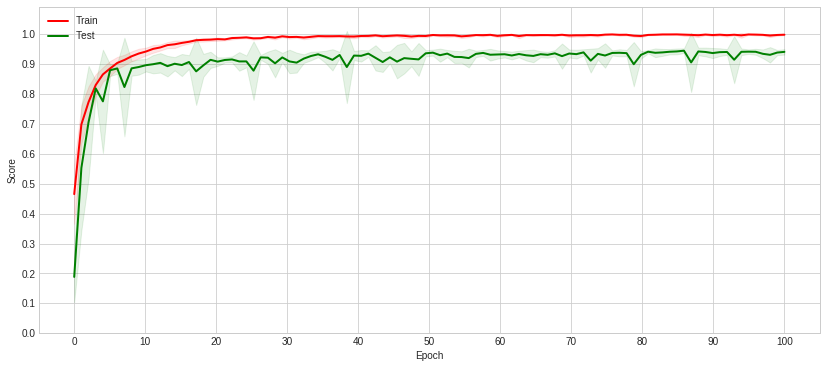

In [11]:
plot_mean_acc(history)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

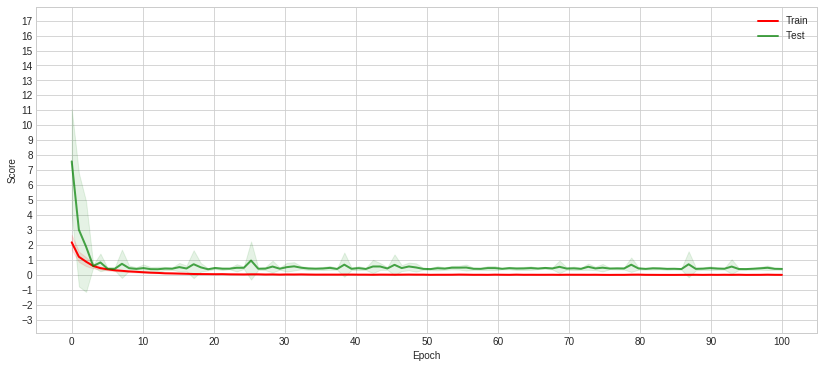

In [13]:
plot_mean_loss(history)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="large"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

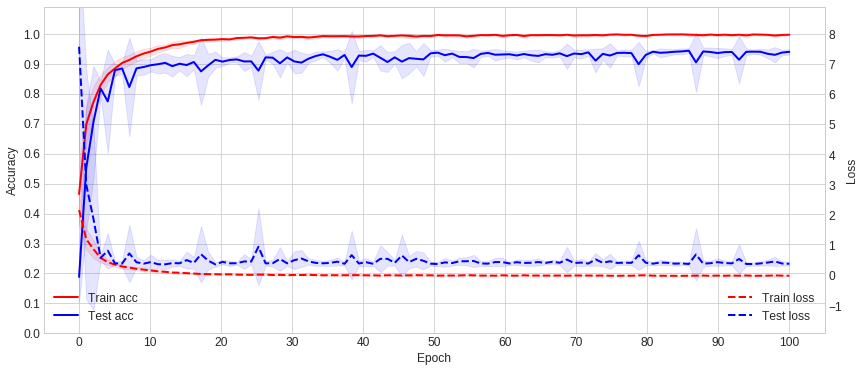

In [56]:
plot_mean(history)